In [73]:
import pandas as pd
import ast
from scipy.stats import norm
import numpy as np

# Abstract level CT annotation and evaluation

In [19]:
!pip install abbreviations

DEPRECATION: prodigy 1.11.8 has a non-standard dependency specifier srsly>=2.0.0<3.0.0. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of prodigy or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [20]:
import pandas as pd
from abbreviations import schwartz_hearst

In [21]:
pairs = schwartz_hearst.extract_abbreviation_definition_pairs(doc_text='The emergency room (ER) was busy')
pairs

{'ER': 'emergency room'}

In [22]:
annotated_files_path_prefix = "./predictions/"

## Load BERT models annotations and Target Test Set

In [137]:
hugging_face_model_name_biolink = "michiyasunaga/BioLinkBERT-base"
model_name_str_biolink = hugging_face_model_name_biolink.split("/")[1]

In [138]:
hugging_face_model_name_biobert = "dmis-lab/biobert-v1.1"
model_name_str_biobert = hugging_face_model_name_biobert.split("/")[1]

In [139]:
hugging_face_model_name_bertbase = "bert-base-uncased"
model_name_str_bertbase = "bert-base-uncased"

In [140]:
# read annotated target dataset 
ds_annotated_full = pd.read_csv("../data/annotated_data/data_splits/ct_neuro_test_merged_90.csv")
col_name_target_annot = "ner_manual_ct_target"
# select only relevant columns
df = ds_annotated_full[['nct_id', 'text', col_name_target_annot]]

In [141]:
biolinkbert_col = f'ner_prediction_{model_name_str_biolink}_normalized'
df_biolinkbert = pd.read_csv(annotated_files_path_prefix + f"ct_neuro_test_annotated_{model_name_str_biolink}_20230916.csv")[['nct_id', biolinkbert_col]]
df = pd.merge(df, df_biolinkbert, on='nct_id', how='left')

In [142]:
biobert_col = f'ner_prediction_{model_name_str_biobert}_normalized'
df_biobert = pd.read_csv(annotated_files_path_prefix + f"ct_neuro_test_annotated_{model_name_str_biobert}_20230916.csv")[['nct_id', biobert_col]]
df = pd.merge(df, df_biobert, on='nct_id', how='left')

In [143]:
bertbase_col = f'ner_prediction_{model_name_str_bertbase}_normalized'
df_bertbase = pd.read_csv(annotated_files_path_prefix + f"ct_neuro_test_annotated_{model_name_str_bertbase}_20240131.csv")[['nct_id', bertbase_col]]
df = pd.merge(df, df_bertbase, on='nct_id', how='left')

In [144]:
df.head(10)

,nct_id,text,ner_manual_ct_target,ner_prediction_BioLinkBERT-base_normalized,ner_prediction_biobert-v1.1_normalized,ner_prediction_bert-base-uncased_normalized
0,NCT04849741,"A Phase 1-3, Double-Blind, Randomized, Placebo...","[(39, 46, 'CONTROL', 'Placebo'), (166, 172, 'D...","[(39, 46, 'CONTROL', 'placebo'), (166, 172, 'D...","[(39, 44, 'CONTROL', 'Place'), (44, 46, 'CONTR...","[(39, 44, 'CONTROL', 'place'), (166, 172, 'DRU..."
1,NCT04576507,Effects of Repeated Cannabis Administration on...,"[(20, 28, 'OTHER', 'Cannabis'), (60, 64, 'COND...","[(20, 28, 'OTHER', 'cannabis'), (60, 64, 'COND...","[(20, 25, 'DRUG', 'Canna'), (25, 28, 'OTHER', ...","[(11, 28, 'OTHER', 'repeated cannabis'), (47, ..."
2,NCT00261508,Efficacy And Safety Of Risperidone In The Trea...,"[(23, 34, 'DRUG', 'Risperidone'), (69, 86, 'CO...","[(23, 34, 'DRUG', 'risperidone'), (69, 86, 'CO...","[(23, 24, 'DRUG', 'R'), (24, 34, 'DRUG', '##is...","[(23, 33, 'DRUG', 'risperidon'), (69, 86, 'CON..."
3,NCT01495923,"Randomized, Double-blind, Comparative-effectiv...","[(77, 84, 'DRUG', 'Steroid'), (99, 109, 'DRUG'...","[(68, 95, 'OTHER', 'epidural steroid injection...","[(68, 79, 'OTHER', 'Epidural St'), (79, 84, 'D...","[(77, 84, 'DRUG', 'steroid'), (99, 109, 'DRUG'..."
4,NCT03150563,Effects of Different Intensities of Passive St...,"[(36, 61, 'OTHER', 'Passive Static Stretching'...","[(36, 61, 'PHYSICAL', 'passive static stretchi...","[(36, 61, 'PHYSICAL', 'Passive Static Stretchi...","[(36, 61, 'OTHER', 'passive static stretching'..."
5,NCT05265377,Safety and Usability of the STELO Exoskeleton ...,"[(28, 45, 'OTHER', 'STELO Exoskeleton'), (61, ...","[(28, 45, 'PHYSICAL', 'stelo exoskeleton'), (6...","[(28, 33, 'OTHER', 'STELO'), (34, 45, 'PHYSICA...","[(28, 31, 'OTHER', 'ste'), (31, 45, 'PHYSICAL'..."
6,NCT03170856,The Effects of a Sub-maximal Exercise Program ...,"[(17, 45, 'PHYSICAL', 'Sub-maximal Exercise Pr...","[(17, 45, 'PHYSICAL', 'sub - maximal exercise ...","[(17, 45, 'PHYSICAL', 'Sub - maximal Exercise ...","[(17, 45, 'PHYSICAL', 'sub - maximal exercise ..."
7,NCT01421056,"A Randomized, Placebo-Controlled, Multicenter ...","[(14, 21, 'CONTROL', 'Placebo'), (121, 129, 'D...","[(14, 21, 'CONTROL', 'placebo'), (121, 129, 'D...","[(14, 19, 'CONTROL', 'Place'), (19, 21, 'CONTR...","[(14, 19, 'CONTROL', 'place'), (121, 129, 'DRU..."
8,NCT04446416,"An Open Label, Prospective, Pilot Study to Eva...","[(137, 151, 'OTHER', 'NaviFUS System'), (169, ...","[(137, 151, 'OTHER', 'navifus system'), (169, ...","[(137, 139, 'OTHER', 'Na'), (141, 151, 'OTHER'...","[(118, 122, 'OTHER', 'care'), (137, 151, 'OTHE..."
9,NCT04212260,Strengthening Oropharyngeal Muscles as a Novel...,"[(0, 35, 'PHYSICAL', 'Strengthening Oropharyng...","[(0, 35, 'PHYSICAL', 'strengthening oropharyng...","[(0, 5, 'PHYSICAL', 'Stren'), (5, 35, 'PHYSICA...","[(14, 35, 'OTHER', 'oropharyngeal muscles'), (..."


In [145]:
# aggregate annotations and sum up how often they were annotated
def extract_summary(annotation_list):
    annotation_list = eval(annotation_list)
    summary = {}
    for annotation in annotation_list:
        _, _, entity_type, entity_name = annotation
        entity_name = entity_name.lower()
        if entity_type not in summary:
            summary[entity_type] = {}
        if entity_name not in summary[entity_type]:
            summary[entity_type][entity_name] = 0
        summary[entity_type][entity_name] += 1
    return summary

In [146]:
df['summary_target_labels'] = df[col_name_target_annot].apply(extract_summary)

In [147]:
df.head(-5)

,nct_id,text,ner_manual_ct_target,ner_prediction_BioLinkBERT-base_normalized,ner_prediction_biobert-v1.1_normalized,ner_prediction_bert-base-uncased_normalized,summary_target_labels
0,NCT04849741,"A Phase 1-3, Double-Blind, Randomized, Placebo...","[(39, 46, 'CONTROL', 'Placebo'), (166, 172, 'D...","[(39, 46, 'CONTROL', 'placebo'), (166, 172, 'D...","[(39, 44, 'CONTROL', 'Place'), (44, 46, 'CONTR...","[(39, 44, 'CONTROL', 'place'), (166, 172, 'DRU...","{'CONTROL': {'placebo': 1}, 'DRUG': {'ion373':..."
1,NCT04576507,Effects of Repeated Cannabis Administration on...,"[(20, 28, 'OTHER', 'Cannabis'), (60, 64, 'COND...","[(20, 28, 'OTHER', 'cannabis'), (60, 64, 'COND...","[(20, 25, 'DRUG', 'Canna'), (25, 28, 'OTHER', ...","[(11, 28, 'OTHER', 'repeated cannabis'), (47, ...","{'OTHER': {'cannabis': 7, 'medicinal cannabis'..."
2,NCT00261508,Efficacy And Safety Of Risperidone In The Trea...,"[(23, 34, 'DRUG', 'Risperidone'), (69, 86, 'CO...","[(23, 34, 'DRUG', 'risperidone'), (69, 86, 'CO...","[(23, 24, 'DRUG', 'R'), (24, 34, 'DRUG', '##is...","[(23, 33, 'DRUG', 'risperidon'), (69, 86, 'CON...","{'DRUG': {'risperidone': 2, 'antipsychotic med..."
3,NCT01495923,"Randomized, Double-blind, Comparative-effectiv...","[(77, 84, 'DRUG', 'Steroid'), (99, 109, 'DRUG'...","[(68, 95, 'OTHER', 'epidural steroid injection...","[(68, 79, 'OTHER', 'Epidural St'), (79, 84, 'D...","[(77, 84, 'DRUG', 'steroid'), (99, 109, 'DRUG'...","{'DRUG': {'steroid': 3, 'gabapentin': 2}, 'CON..."
4,NCT03150563,Effects of Different Intensities of Passive St...,"[(36, 61, 'OTHER', 'Passive Static Stretching'...","[(36, 61, 'PHYSICAL', 'passive static stretchi...","[(36, 61, 'PHYSICAL', 'Passive Static Stretchi...","[(36, 61, 'OTHER', 'passive static stretching'...","{'OTHER': {'passive static stretching': 1, 'mu..."
...,...,...,...,...,...,...,...
80,NCT00909012,Quantitative Requirements of Docosahexaenoic A...,"[(29, 49, 'DRUG', 'Docosahexaenoic Acid'), (87...","[(29, 49, 'DRUG', 'docosahexaenoic acid'), (87...","[(29, 49, 'DRUG', 'Docosahexaenoic Acid'), (87...","[(29, 49, 'DRUG', 'docosahexaenoic acid'), (87...","{'DRUG': {'docosahexaenoic acid': 2, 'dha': 7}..."
81,NCT04955249,Impact of Dexmedetomidine Supplemented Analges...,"[(10, 25, 'DRUG', 'Dexmedetomidine'), (52, 60,...","[(10, 25, 'DRUG', 'dexmedetomidine'), (52, 60,...","[(10, 25, 'DRUG', 'Dexmedetomidine'), (52, 60,...","[(10, 21, 'DRUG', 'dexmedetomi'), (52, 60, 'CO...","{'DRUG': {'dexmedetomidine': 2}, 'CONDITION': ..."
82,NCT00252850,"A Phase I, Open-Label Study of CERE-120 (Adeno...","[(31, 39, 'OTHER', 'CERE-120'), (41, 96, 'OTHE...","[(31, 39, 'DRUG', 'cere - 120'), (41, 46, 'OTH...","[(31, 39, 'DRUG', 'CERE - 120'), (41, 74, 'DRU...","[(31, 39, 'DRUG', 'cere - 120'), (41, 45, 'DRU...","{'OTHER': {'cere-120': 3, 'adeno-associated vi..."
83,NCT02840643,Combined Constraint Therapy and Bimanual Thera...,"[(9, 27, 'PHYSICAL', 'Constraint Therapy'), (3...","[(0, 27, 'OTHER', 'combined constraint therapy...","[(0, 8, 'PHYSICAL', 'Combined'), (9, 27, 'PHYS...","[(0, 27, 'OTHER', 'combined constraint therapy...","{'PHYSICAL': {'constraint therapy': 1, 'bimanu..."


In [148]:
print(df['summary_target_labels'][6])

{'PHYSICAL': {'sub-maximal exercise program': 1, 'sub-maximal exercise protocol': 1}, 'CONDITION': {'concussion': 2}}


In [149]:
# Define a function to extract the unique conditions, drugs, and others from the 'ner_manual_final_annotated_ds' column
def extract_unique_entities_count(annotation_list, abbreviation_definition_pairs):
    unique_conditions = set()
    unique_drugs = set()
    unique_others = set()
    annotation_list = eval(annotation_list)
    for annotation in annotation_list:
        _, _, entity_type, entity_name = annotation
        if entity_name in abbreviation_definition_pairs:
            #print("Skipping entity {} as it is an ABBR".format(entity_name))
            continue
        entity_name = entity_name.lower()
        if entity_type == 'CONDITION':
            unique_conditions.add(entity_name)
        elif entity_type == 'DRUG':
            unique_drugs.add(entity_name)
        elif entity_type == 'OTHER':
            unique_others.add(entity_name)
    return len(unique_conditions), len(unique_drugs), len(unique_others)

def extract_unique_entities(annotation_list, abbreviation_definition_pairs, model="linkbert", exclude_drug=True):
    unique_conditions = set()
    unique_control = set()
    unique_physical = set()
    unique_behavioural = set()
    unique_surgical = set()
    unique_radiotherapy = set()
    unique_other = set()

    annotation_list = eval(annotation_list)
    
    for annotation in annotation_list:
        _, _, entity_type, entity_name = annotation
        if entity_name.startswith("##"):
            continue  # THERE IS AN ISSUE WITH BIOBERT and BERT
        if (len(entity_name) == 1 or len(entity_name) == 2) and model == "biobert":
            continue  # ASSUME TOKENIZER ERROR IN BIOBERT
        # REPLACE ABBREVIATIONS WITH FULL FORM
        if entity_name in abbreviation_definition_pairs:
            entity_name = abbreviation_definition_pairs[entity_name] 
        if entity_name.upper() in abbreviation_definition_pairs:
            entity_name = abbreviation_definition_pairs[entity_name.upper()]
        entity_name = entity_name.lower()
        
        # Categorizing entities based on their type
        if entity_type == 'CONDITION':
            unique_conditions.add(entity_name)
        elif entity_type == 'CONTROL':
            unique_control.add(entity_name)
        elif entity_type == 'PHYSICAL':
            unique_physical.add(entity_name)
        elif entity_type == 'BEHAVIOURAL':
            unique_behavioural.add(entity_name)
        elif entity_type == 'SURGICAL':
            unique_surgical.add(entity_name)
        elif entity_type == 'RADIOTHERAPY':
            unique_radiotherapy.add(entity_name)
        elif entity_type == 'OTHER':
            unique_other.add(entity_name)
        
    # Preparing the output
    conditions_str = "|".join(sorted(list(unique_conditions)))
    control_str = "|".join(sorted(list(unique_control)))
    physical_str = "|".join(sorted(list(unique_physical)))
    behavioural_str = "|".join(sorted(list(unique_behavioural)))
    surgical_str = "|".join(sorted(list(unique_surgical)))
    radiotherapy_str = "|".join(sorted(list(unique_radiotherapy)))
    other_str = "|".join(sorted(list(unique_other)))

    # Returning a tuple containing all the unique entities by category
    return conditions_str, control_str, physical_str, behavioural_str, surgical_str, radiotherapy_str, other_str


# Placeholder function to demonstrate applying the Schwartz-Hearst algorithm (Replace with actual implementation)
def extract_abbreviation_definition_pairs(doc_text):
    pairs = schwartz_hearst.extract_abbreviation_definition_pairs(doc_text=doc_text)
    return pairs

In [150]:
# Create a new column 'abbreviation_definition_pairs' using the 'apply' function
df['abbreviation_definition_pairs'] = df['text'].apply(extract_abbreviation_definition_pairs)

# Apply the function to each row and create new columns 'num_unique_conditions', 'num_unique_drugs', and 'num_unique_others'
#df['unique_conditions_target'], df['unique_interventions_target'], df['unique_interventions_type_target'] = zip(*df.apply(lambda row: extract_unique_entities(row[col_name_target_annot], row['abbreviation_definition_pairs']), axis=1))
#df[f'unique_conditions_{model_name_str_biolink}_predictions'], df[f'unique_interventions_{model_name_str_biolink}_predictions'], df[f'unique_interventions_type_{model_name_str_biolink}_predictions'] = zip(*df.apply(lambda row: extract_unique_entities(row[biolinkbert_col], row['abbreviation_definition_pairs']), axis=1))
#df[f'unique_conditions_{model_name_str_biobert}_predictions'], df[f'unique_interventions_{model_name_str_biobert}_predictions'], df[f'unique_interventions_type_{model_name_str_biobert}_predictions'] = zip(*df.apply(lambda row: extract_unique_entities(row[biobert_col], row['abbreviation_definition_pairs'], model="biobert"), axis=1))
#df[f'unique_conditions_{model_name_str_bertbase}_predictions'], df[f'unique_interventions_{model_name_str_bertbase}_predictions'], df[f'unique_interventions_type_{model_name_str_bertbase}_predictions'] = zip(*df.apply(lambda row: extract_unique_entities(row[bertbase_col], row['abbreviation_definition_pairs'], model="biobert"), axis=1))

model_names = ["target", model_name_str_biolink, model_name_str_biobert, model_name_str_bertbase]  # Example model names, adjust as necessary
model_cols = [col_name_target_annot, biolinkbert_col, biobert_col, bertbase_col]
i = 0
for model_name in model_names:
    results = df.apply(lambda row: extract_unique_entities(row[model_cols[i]], row['abbreviation_definition_pairs'], model=model_name, exclude_drug=True), axis=1)
    df[f'unique_conditions_{model_name}'] = results.apply(lambda x: x[0])
    df[f'unique_control_{model_name}'] = results.apply(lambda x: x[1])
    df[f'unique_physical_{model_name}'] = results.apply(lambda x: x[2])
    df[f'unique_behavioural_{model_name}'] = results.apply(lambda x: x[3])
    df[f'unique_surgical_{model_name}'] = results.apply(lambda x: x[4])
    df[f'unique_radiotherapy_{model_name}'] = results.apply(lambda x: x[5])
    df[f'unique_other_{model_name}'] = results.apply(lambda x: x[6])
    i += 1


In [151]:
df.head()

,nct_id,text,ner_manual_ct_target,ner_prediction_BioLinkBERT-base_normalized,ner_prediction_biobert-v1.1_normalized,ner_prediction_bert-base-uncased_normalized,summary_target_labels,abbreviation_definition_pairs,unique_conditions_target,unique_control_target,...,unique_surgical_biobert-v1.1,unique_radiotherapy_biobert-v1.1,unique_other_biobert-v1.1,unique_conditions_bert-base-uncased,unique_control_bert-base-uncased,unique_physical_bert-base-uncased,unique_behavioural_bert-base-uncased,unique_surgical_bert-base-uncased,unique_radiotherapy_bert-base-uncased,unique_other_bert-base-uncased
0,NCT04849741,"A Phase 1-3, Double-Blind, Randomized, Placebo...","[(39, 46, 'CONTROL', 'Placebo'), (166, 172, 'D...","[(39, 46, 'CONTROL', 'placebo'), (166, 172, 'D...","[(39, 44, 'CONTROL', 'Place'), (44, 46, 'CONTR...","[(39, 44, 'CONTROL', 'place'), (166, 172, 'DRU...","{'CONTROL': {'placebo': 1}, 'DRUG': {'ion373':...",{},alexander disease|axd.,placebo,...,,,,alexander disease|axd,place,,,,,
1,NCT04576507,Effects of Repeated Cannabis Administration on...,"[(20, 28, 'OTHER', 'Cannabis'), (60, 64, 'COND...","[(20, 28, 'OTHER', 'cannabis'), (60, 64, 'COND...","[(20, 25, 'DRUG', 'Canna'), (25, 28, 'OTHER', ...","[(11, 28, 'OTHER', 'repeated cannabis'), (47, ...","{'OTHER': {'cannabis': 7, 'medicinal cannabis'...","{'THC': 'tetrahydrocannabinol', 'CBD': 'cannab...",chronic pain|pain,placebo,...,,,cannabis,abuse|chronic pain|experimental pain|pain,place,,,,,cannabis|high - cbd cannabis|repeated cannabis
2,NCT00261508,Efficacy And Safety Of Risperidone In The Trea...,"[(23, 34, 'DRUG', 'Risperidone'), (69, 86, 'CO...","[(23, 34, 'DRUG', 'risperidone'), (69, 86, 'CO...","[(23, 24, 'DRUG', 'R'), (24, 34, 'DRUG', '##is...","[(23, 33, 'DRUG', 'risperidon'), (69, 86, 'CON...","{'DRUG': {'risperidone': 2, 'antipsychotic med...",{'PDD': 'Pervasive Developmental Disorders'},autistic disorder|pervasive developmental diso...,placebo,...,,,,autistic disorder|per|pervasive developmental ...,place,,,,,
3,NCT01495923,"Randomized, Double-blind, Comparative-effectiv...","[(77, 84, 'DRUG', 'Steroid'), (99, 109, 'DRUG'...","[(68, 95, 'OTHER', 'epidural steroid injection...","[(68, 79, 'OTHER', 'Epidural St'), (79, 84, 'D...","[(77, 84, 'DRUG', 'steroid'), (99, 109, 'DRUG'...","{'DRUG': {'steroid': 3, 'gabapentin': 2}, 'CON...",{'ESI': 'epidural steroid injection'},lumbosacral radicular pain|lumbosacral radicul...,,...,,,e|epidural s|epidural st|injection,lu|pain,,,,,,
4,NCT03150563,Effects of Different Intensities of Passive St...,"[(36, 61, 'OTHER', 'Passive Static Stretching'...","[(36, 61, 'PHYSICAL', 'passive static stretchi...","[(36, 61, 'PHYSICAL', 'Passive Static Stretchi...","[(36, 61, 'OTHER', 'passive static stretching'...","{'OTHER': {'passive static stretching': 1, 'mu...",{},,,...,,,,,,,,,,muscle stretching|passive static stretching|st...


In [152]:
#df.to_csv("temp_sanity_check_all_entitites.csv")

In [153]:
#df['num_unique_conditions'], df['num_unique_drugs'], df['num_unique_others'] = zip(*df.apply(lambda row: extract_unique_entities_count(row[col_name_target_annot], row['abbreviation_definition_pairs']), axis=1))


In [154]:
df.head(2)

,nct_id,text,ner_manual_ct_target,ner_prediction_BioLinkBERT-base_normalized,ner_prediction_biobert-v1.1_normalized,ner_prediction_bert-base-uncased_normalized,summary_target_labels,abbreviation_definition_pairs,unique_conditions_target,unique_control_target,...,unique_surgical_biobert-v1.1,unique_radiotherapy_biobert-v1.1,unique_other_biobert-v1.1,unique_conditions_bert-base-uncased,unique_control_bert-base-uncased,unique_physical_bert-base-uncased,unique_behavioural_bert-base-uncased,unique_surgical_bert-base-uncased,unique_radiotherapy_bert-base-uncased,unique_other_bert-base-uncased
0,NCT04849741,"A Phase 1-3, Double-Blind, Randomized, Placebo...","[(39, 46, 'CONTROL', 'Placebo'), (166, 172, 'D...","[(39, 46, 'CONTROL', 'placebo'), (166, 172, 'D...","[(39, 44, 'CONTROL', 'Place'), (44, 46, 'CONTR...","[(39, 44, 'CONTROL', 'place'), (166, 172, 'DRU...","{'CONTROL': {'placebo': 1}, 'DRUG': {'ion373':...",{},alexander disease|axd.,placebo,...,,,,alexander disease|axd,place,,,,,
1,NCT04576507,Effects of Repeated Cannabis Administration on...,"[(20, 28, 'OTHER', 'Cannabis'), (60, 64, 'COND...","[(20, 28, 'OTHER', 'cannabis'), (60, 64, 'COND...","[(20, 25, 'DRUG', 'Canna'), (25, 28, 'OTHER', ...","[(11, 28, 'OTHER', 'repeated cannabis'), (47, ...","{'OTHER': {'cannabis': 7, 'medicinal cannabis'...","{'THC': 'tetrahydrocannabinol', 'CBD': 'cannab...",chronic pain|pain,placebo,...,,,cannabis,abuse|chronic pain|experimental pain|pain,place,,,,,cannabis|high - cbd cannabis|repeated cannabis


In [155]:
filtered_columns = ['nct_id'] + [col for col in df.columns if 'unique' in col]
df_unique_labels = df[filtered_columns]

In [156]:
df_unique_labels.head(4)

,nct_id,unique_conditions_target,unique_control_target,unique_physical_target,unique_behavioural_target,unique_surgical_target,unique_radiotherapy_target,unique_other_target,unique_conditions_BioLinkBERT-base,unique_control_BioLinkBERT-base,...,unique_surgical_biobert-v1.1,unique_radiotherapy_biobert-v1.1,unique_other_biobert-v1.1,unique_conditions_bert-base-uncased,unique_control_bert-base-uncased,unique_physical_bert-base-uncased,unique_behavioural_bert-base-uncased,unique_surgical_bert-base-uncased,unique_radiotherapy_bert-base-uncased,unique_other_bert-base-uncased
0,NCT04849741,alexander disease|axd.,placebo,,,,,,alexander disease|axd,placebo,...,,,,alexander disease|axd,place,,,,,
1,NCT04576507,chronic pain|pain,placebo,,,,,cannabis|high-cbd cannabis|medicinal cannabis,chronic pain|hyperalgesia|pain,placebo,...,,,cannabis,abuse|chronic pain|experimental pain|pain,place,,,,,cannabis|high - cbd cannabis|repeated cannabis
2,NCT00261508,autistic disorder|pervasive developmental diso...,placebo,,,,,,autistic disorder|pervasive developmental diso...,placebo,...,,,,autistic disorder|per|pervasive developmental ...,place,,,,,
3,NCT01495923,lumbosacral radicular pain|lumbosacral radicul...,,,,,,,lumbosacral radicular pain|lumbosacral radicul...,,...,,,e|epidural s|epidural st|injection,lu|pain,,,,,,


In [157]:
# Your function to remove spaces around specific characters
def cleanup(text):
    if isinstance(text, str):  # Check if the cell value is a string
        text = text.replace(" ' ", "'")  # Remove spaces around '
        text = text.replace("' s", "'s")  # Remove spaces around '
        text = text.replace(" - ", "-")  # Remove spaces around -
        text = text.replace(" / ", "/")  # Remove spaces around /
        text = text.replace("( ", "(")  # Remove spaces around (
        text = text.replace(" )", ")")  # Remove spaces around )
        #text = text.replace("place ", "placebo")  # Remove spaces around )
    return text

# Apply the function to each cell in the DataFrame
df_unique_labels = df_unique_labels.applymap(cleanup)

In [158]:
df_unique_labels.head(2)

,nct_id,unique_conditions_target,unique_control_target,unique_physical_target,unique_behavioural_target,unique_surgical_target,unique_radiotherapy_target,unique_other_target,unique_conditions_BioLinkBERT-base,unique_control_BioLinkBERT-base,...,unique_surgical_biobert-v1.1,unique_radiotherapy_biobert-v1.1,unique_other_biobert-v1.1,unique_conditions_bert-base-uncased,unique_control_bert-base-uncased,unique_physical_bert-base-uncased,unique_behavioural_bert-base-uncased,unique_surgical_bert-base-uncased,unique_radiotherapy_bert-base-uncased,unique_other_bert-base-uncased
0,NCT04849741,alexander disease|axd.,placebo,,,,,,alexander disease|axd,placebo,...,,,,alexander disease|axd,place,,,,,
1,NCT04576507,chronic pain|pain,placebo,,,,,cannabis|high-cbd cannabis|medicinal cannabis,chronic pain|hyperalgesia|pain,placebo,...,,,cannabis,abuse|chronic pain|experimental pain|pain,place,,,,,cannabis|high-cbd cannabis|repeated cannabis


## Evaluation scripts

In [159]:
def exact_match(prediction, target):
    true_positive = 0
    false_positive = 0
    false_negative = 0

    for target_string in target:
        if target_string in prediction:
            true_positive += 1
        else:
            false_negative += 1

    for prediction_string in prediction:
        if prediction_string not in target:
            false_positive += 1

    return true_positive, false_positive, false_negative

# Example usage:
target = ["carbon-14 bia 28-6156", "bia 28-6156"]
prediction = ["bia 28-6156"]

tp, fp, fn = exact_match(prediction, target)
print("True Positives:", tp)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 1
False Positives: 0
False Negatives: 1


In [160]:
def majority_rule_match(prediction, target):
    true_positive = 0
    false_positive = 0
    false_negative = 0
    
    for target_string in target:
        target_words = target_string.split()
        matching_count = 0

        for prediction_string in prediction:
            prediction_words = prediction_string.split()
            common_words = set(target_words) & set(prediction_words)

            # Check if more than half of the words overlap
            if len(common_words) > len(target_words) / 2:
                matching_count += 1

        if matching_count > 0:
            true_positive += 1
        else:
            false_negative += 1

    for prediction_string in prediction:
        prediction_words = prediction_string.split()
        matching_count = 0

        for target_string in target:
            target_words = target_string.split()
            common_words = set(target_words) & set(prediction_words)

            # Check if more than half of the words overlap
            if len(common_words) > len(target_words) / 2:
                matching_count += 1

        if matching_count == 0:
            false_positive += 1

    return true_positive, false_positive, false_negative

# Example usage:
target = ["carbon-14 bia 28-6156", "bia 28-6156"]
prediction = ["bia 28-6156"]

tp, fp, fn = majority_rule_match(prediction, target)
print("True Positives:", tp)
print("False Positives:", fp)
print("False Negatives:", fn)


True Positives: 2
False Positives: 0
False Negatives: 0


In [161]:
def f1_score(precision, recall):
    if precision > 0 or recall > 0:
        f1 = 2 * ((precision * recall) / (precision + recall))
    else:
        f1 = 0
    return f1

def calculate_precision_recall_v2(prediction, target, method="exact_match", threshold=None):
    if len(set(prediction)) == 1 and len(set(target)) == 1 and list(set(prediction)) == list(set(target)) == ['']:
        return {"p": 0, "r": 0, "f1": 0}
    target_set = set([str(t).lower() for t in target])
    prediction_set = set([str(p).lower() for p in prediction])
    
    #print(prediction_set, target_set)
    
    if method == "exact_match":
        tp, fp, fn = exact_match(list(prediction_set), list(target_set))
    else:
        tp, fp, fn = majority_rule_match(list(prediction_set), list(target_set))
    #print(tp,fp,fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = f1_score(precision, recall)
 
    return {"p":round(precision,2), "r":round(recall,2), "f1":round(f1,2)}

def calculate_tp_fp_fn(prediction, target, method="exact_match", threshold=None):
    if len(set(prediction)) == 1 and len(set(target)) == 1 and list(set(prediction)) == list(set(target)) == ['']:
        return {"tp": 0, "fp": 0, "fn": 0}
    target_set = set([str(t).lower() for t in target])
    prediction_set = set([str(p).lower() for p in prediction])
    
    #print(prediction_set, target_set)
    
    if method == "exact_match":
        tp, fp, fn = exact_match(list(prediction_set), list(target_set))
    else:
        tp, fp, fn = majority_rule_match(list(prediction_set), list(target_set))
 
    return {"tp":round(tp,2), "fp":round(fp,2), "fn":round(fn,2)}

In [162]:
def wilson_score_interval(tp, fp, fn, metric):
    confidence=0.95
    x = tp
    if metric == "precision":
        n = tp + fp
    elif metric == "recall":
        n = tp + fn
    elif metric == "f1":
        x = 2 * tp
        n = 2 * tp + fp + fn
    else:
        return (0, 0, 0)

    z = norm.ppf(1 - (1 - confidence) / 2)
    phat = x / n
    center = (x + z ** 2 / 2) / (n + z ** 2)

    interval = ((z * np.sqrt(n)) / (n + z ** 2)) * np.sqrt(phat * (1 - phat) + z ** 2 / (4 * n))

    lower_bound = center - interval
    upper_bound = center + interval
    
    if phat == 0:
        return (0,0,0)
    
    return round(lower_bound,3), round(phat,3), round(upper_bound,3)

In [163]:
df_unique_labels.head(2)

,nct_id,unique_conditions_target,unique_control_target,unique_physical_target,unique_behavioural_target,unique_surgical_target,unique_radiotherapy_target,unique_other_target,unique_conditions_BioLinkBERT-base,unique_control_BioLinkBERT-base,...,unique_surgical_biobert-v1.1,unique_radiotherapy_biobert-v1.1,unique_other_biobert-v1.1,unique_conditions_bert-base-uncased,unique_control_bert-base-uncased,unique_physical_bert-base-uncased,unique_behavioural_bert-base-uncased,unique_surgical_bert-base-uncased,unique_radiotherapy_bert-base-uncased,unique_other_bert-base-uncased
0,NCT04849741,alexander disease|axd.,placebo,,,,,,alexander disease|axd,placebo,...,,,,alexander disease|axd,place,,,,,
1,NCT04576507,chronic pain|pain,placebo,,,,,cannabis|high-cbd cannabis|medicinal cannabis,chronic pain|hyperalgesia|pain,placebo,...,,,cannabis,abuse|chronic pain|experimental pain|pain,place,,,,,cannabis|high-cbd cannabis|repeated cannabis


In [164]:
model_names = [model_name_str_biolink, model_name_str_biobert, model_name_str_bertbase]
model_names

['BioLinkBERT-base', 'biobert-v1.1', 'bert-base-uncased']

In [165]:
df_eval = df_unique_labels.copy()
df_eval.head()

,nct_id,unique_conditions_target,unique_control_target,unique_physical_target,unique_behavioural_target,unique_surgical_target,unique_radiotherapy_target,unique_other_target,unique_conditions_BioLinkBERT-base,unique_control_BioLinkBERT-base,...,unique_surgical_biobert-v1.1,unique_radiotherapy_biobert-v1.1,unique_other_biobert-v1.1,unique_conditions_bert-base-uncased,unique_control_bert-base-uncased,unique_physical_bert-base-uncased,unique_behavioural_bert-base-uncased,unique_surgical_bert-base-uncased,unique_radiotherapy_bert-base-uncased,unique_other_bert-base-uncased
0,NCT04849741,alexander disease|axd.,placebo,,,,,,alexander disease|axd,placebo,...,,,,alexander disease|axd,place,,,,,
1,NCT04576507,chronic pain|pain,placebo,,,,,cannabis|high-cbd cannabis|medicinal cannabis,chronic pain|hyperalgesia|pain,placebo,...,,,cannabis,abuse|chronic pain|experimental pain|pain,place,,,,,cannabis|high-cbd cannabis|repeated cannabis
2,NCT00261508,autistic disorder|pervasive developmental diso...,placebo,,,,,,autistic disorder|pervasive developmental diso...,placebo,...,,,,autistic disorder|per|pervasive developmental ...,place,,,,,
3,NCT01495923,lumbosacral radicular pain|lumbosacral radicul...,,,,,,,lumbosacral radicular pain|lumbosacral radicul...,,...,,,e|epidural s|epidural st|injection,lu|pain,,,,,,
4,NCT03150563,,,,,,,"muscle stretching protocol,|passive static str...",,,...,,,,,,,,,,muscle stretching|passive static stretching|st...


### add GPT

In [166]:
df_gpt_3_5 = pd.read_csv("./predictions/rebuttal/ct_neuro_test_annotated_gpt-3.5-turbo_additional_types_20240408_clean.csv")
df_gpt_4 = pd.read_csv("./predictions/rebuttal/ct_neuro_test_annotated_gpt-4_additional_types_20240408_clean.csv")

def clean_and_rename_columns(df, model_name):
    # Filter out columns starting with "Unnamed"
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df = df.loc[:, ~df.columns.str.contains('text')]

    
    # Rename the columns based on your criteria
    new_column_names = {
        'nct_id': 'nct_id'
    }

    # For each of the remaining columns, create a new column name based on your template
    for col in df.columns:
        if col.startswith(f'{model_name}_predictions'):
            # Extract the entity type from the column name
            entity_type = col.split('_')[-1]
            # Construct the new column name
            new_column_name = f'unique_{entity_type}_{model_name}'
            new_column_names[col] = new_column_name

    # Apply the new column names
    df.rename(columns=new_column_names, inplace=True)
    
    return df

# Clean and rename columns for each DataFrame
df_gpt_3_5_cleaned = clean_and_rename_columns(df_gpt_3_5, "gpt-3.5-turbo")
df_gpt_4_cleaned = clean_and_rename_columns(df_gpt_4, "gpt-4")

In [167]:
df_gpt_3_5_cleaned.head(2)

,nct_id,unique_behavioural_gpt-3.5-turbo,unique_surgical_gpt-3.5-turbo,unique_radiotherapy_gpt-3.5-turbo,unique_physical_gpt-3.5-turbo,unique_other_gpt-3.5-turbo,unique_control_gpt-3.5-turbo
0,NCT04849741,none,none,none,none,none,none
1,NCT04576507,none,none,none,smoking cannabis 3x/day,cannabinoids,none


In [134]:
df_gpt_4_cleaned.head(2)

,nct_id,unique_behavioural_gpt-4,unique_surgical_gpt-4,unique_radiotherapy_gpt-4,unique_physical_gpt-4,unique_other_gpt-4,unique_control_gpt-4
0,NCT04849741,none,none,none,intrathecally administered ion373,placebo|intrathecally administered ion373,placebo
1,NCT04576507,none,none,none,smoking cannabis 3x/day|quantitative sensory t...,prescription opioids|cannabis|delta-9-tetrahyd...,placebo


In [168]:
df_eval = pd.merge(df_eval, df_gpt_3_5_cleaned, on='nct_id', how='left')
df_eval = pd.merge(df_eval, df_gpt_4_cleaned, on='nct_id', how='left')


In [169]:
df_eval.head()

,nct_id,unique_conditions_target,unique_control_target,unique_physical_target,unique_behavioural_target,unique_surgical_target,unique_radiotherapy_target,unique_other_target,unique_conditions_BioLinkBERT-base,unique_control_BioLinkBERT-base,...,unique_radiotherapy_gpt-3.5-turbo,unique_physical_gpt-3.5-turbo,unique_other_gpt-3.5-turbo,unique_control_gpt-3.5-turbo,unique_behavioural_gpt-4,unique_surgical_gpt-4,unique_radiotherapy_gpt-4,unique_physical_gpt-4,unique_other_gpt-4,unique_control_gpt-4
0,NCT04849741,alexander disease|axd.,placebo,,,,,,alexander disease|axd,placebo,...,none,none,none,none,none,none,none,intrathecally administered ion373,placebo|intrathecally administered ion373,placebo
1,NCT04576507,chronic pain|pain,placebo,,,,,cannabis|high-cbd cannabis|medicinal cannabis,chronic pain|hyperalgesia|pain,placebo,...,none,smoking cannabis 3x/day,cannabinoids,none,none,none,none,smoking cannabis 3x/day|quantitative sensory t...,prescription opioids|cannabis|delta-9-tetrahyd...,placebo
2,NCT00261508,autistic disorder|pervasive developmental diso...,placebo,,,,,,autistic disorder|pervasive developmental diso...,placebo,...,none,placebo|oral solution of risperidone,none,placebo,none,none,none,none,antipsychotic medication|risperidone|oral solu...,placebo
3,NCT01495923,lumbosacral radicular pain|lumbosacral radicul...,,,,,,,lumbosacral radicular pain|lumbosacral radicul...,,...,esi|gabapentin,epidural steroid injections|gabapentin,none,epidural steroid injections|gabapentin,epidural steroid injections|gabapentin,epidural steroid injections,none,epidural steroid injections|gabapentin,epidural steroid injections|gabapentin,epidural steroid injections|gabapentin
4,NCT03150563,,,,,,,"muscle stretching protocol,|passive static str...",,,...,none,passive static stretching,none,none,none,none,none,passive static stretching,passive static stretching,none


### Run Evaluations

In [174]:
model_names

['BioLinkBERT-base', 'biobert-v1.1', 'bert-base-uncased']

In [175]:
model_names = model_names + ['gpt-3.5-turbo', 'gpt-4']
model_names

['BioLinkBERT-base',
 'biobert-v1.1',
 'bert-base-uncased',
 'gpt-3.5-turbo',
 'gpt-4']

In [176]:
entity_types = ["behavioural", "surgical", "radiotherapy", "physical", "other", "control"]
methods = ["exact_match", "majority"] #, "majority", "levenshtein", "at_least_one", "at_least_one_overall"
#model_names = [model_name_str_biolink, model_name_str_biobert, model_name_str_bertbase]

for model in model_names:
    for method in methods:
        for entity_type in entity_types:
            col_to_eval = f'unique_{entity_type}_{model}'
            column_name = f"eval_{method}_{model}_{entity_type}"
            column_name_basic_metrics = f"eval_{method}_{model}_{entity_type}_tp_fp_fn"
            target_col = f'unique_{entity_type}_target'
            print(f"*** Eval {model} {method} {entity_type}***")
            df_eval[column_name] =  df_eval.apply(lambda row: calculate_precision_recall_v2(row[col_to_eval].split("|"), row[target_col].split("|"), method=method, threshold=0.5), axis=1)
            df_eval[column_name_basic_metrics] =  df_eval.apply(lambda row: calculate_tp_fp_fn(row[col_to_eval].split("|"), row[target_col].split("|"), method=method, threshold=0.5), axis=1)  

*** Eval BioLinkBERT-base exact_match behavioural***
*** Eval BioLinkBERT-base exact_match surgical***
*** Eval BioLinkBERT-base exact_match radiotherapy***
*** Eval BioLinkBERT-base exact_match physical***
*** Eval BioLinkBERT-base exact_match other***
*** Eval BioLinkBERT-base exact_match control***
*** Eval BioLinkBERT-base majority behavioural***
*** Eval BioLinkBERT-base majority surgical***
*** Eval BioLinkBERT-base majority radiotherapy***
*** Eval BioLinkBERT-base majority physical***
*** Eval BioLinkBERT-base majority other***
*** Eval BioLinkBERT-base majority control***
*** Eval biobert-v1.1 exact_match behavioural***
*** Eval biobert-v1.1 exact_match surgical***
*** Eval biobert-v1.1 exact_match radiotherapy***
*** Eval biobert-v1.1 exact_match physical***
*** Eval biobert-v1.1 exact_match other***
*** Eval biobert-v1.1 exact_match control***
*** Eval biobert-v1.1 majority behavioural***
*** Eval biobert-v1.1 majority surgical***
*** Eval biobert-v1.1 majority radiotherapy*

In [177]:
df_eval.head()

,nct_id,unique_conditions_target,unique_control_target,unique_physical_target,unique_behavioural_target,unique_surgical_target,unique_radiotherapy_target,unique_other_target,unique_conditions_BioLinkBERT-base,unique_control_BioLinkBERT-base,...,eval_majority_gpt-4_surgical,eval_majority_gpt-4_surgical_tp_fp_fn,eval_majority_gpt-4_radiotherapy,eval_majority_gpt-4_radiotherapy_tp_fp_fn,eval_majority_gpt-4_physical,eval_majority_gpt-4_physical_tp_fp_fn,eval_majority_gpt-4_other,eval_majority_gpt-4_other_tp_fp_fn,eval_majority_gpt-4_control,eval_majority_gpt-4_control_tp_fp_fn
0,NCT04849741,alexander disease|axd.,placebo,,,,,,alexander disease|axd,placebo,...,"{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 1}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 1}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 1}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 2, 'fn': 1}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}"
1,NCT04576507,chronic pain|pain,placebo,,,,,cannabis|high-cbd cannabis|medicinal cannabis,chronic pain|hyperalgesia|pain,placebo,...,"{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 1}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 1}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 3, 'fn': 1}","{'p': 0.17, 'r': 0.33, 'f1': 0.22}","{'tp': 1, 'fp': 5, 'fn': 2}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}"
2,NCT00261508,autistic disorder|pervasive developmental diso...,placebo,,,,,,autistic disorder|pervasive developmental diso...,placebo,...,"{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 1}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 1}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 1}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 4, 'fn': 1}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}"
3,NCT01495923,lumbosacral radicular pain|lumbosacral radicul...,,,,,,,lumbosacral radicular pain|lumbosacral radicul...,,...,"{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 1}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 1}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 2, 'fn': 1}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 2, 'fn': 1}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 2, 'fn': 1}"
4,NCT03150563,,,,,,,"muscle stretching protocol,|passive static str...",,,...,"{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 1}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 1}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 1}","{'p': 1.0, 'r': 0.67, 'f1': 0.8}","{'tp': 2, 'fp': 0, 'fn': 1}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 1}"


In [178]:
# Initialize a dictionary to hold F1 results for each entity type
results_f1 = {entity: {} for entity in entity_types}
results_f1

{'behavioural': {},
 'surgical': {},
 'radiotherapy': {},
 'physical': {},
 'other': {},
 'control': {}}

In [179]:
methods

['exact_match', 'majority']

In [180]:
# Initialize a dictionary to hold F1 results for each entity type
results_f1_majority = {entity: {} for entity in entity_types}
results_f1_exact = {entity: {} for entity in entity_types}


for model in model_names:
    for method in methods:
        for entity_type in entity_types:
            column_name = f'eval_{method}_{model}_{entity_type}_tp_fp_fn'
            print(f"*** {column_name} ***")
            tp_sum = df_eval[column_name].apply(lambda x: x['tp']).sum()
            fp_sum = df_eval[column_name].apply(lambda x: x['fp']).sum()
            fn_sum = df_eval[column_name].apply(lambda x: x['fn']).sum()
            print("* F1 *")
            result = wilson_score_interval(tp_sum, fp_sum, fn_sum, "f1")

            result_key = f"{method}_{model}"
            # Update results_f1 with structured data
            if "exact" in method:
                if result_key not in results_f1_exact[entity_type]:
                    results_f1_exact[entity_type][result_key] = []
                results_f1_exact[entity_type][result_key].append(result)
            else:
                if result_key not in results_f1_majority[entity_type]:
                    results_f1_majority[entity_type][result_key] = []
                results_f1_majority[entity_type][result_key].append(result)
            
            print(result)

*** eval_exact_match_BioLinkBERT-base_behavioural_tp_fp_fn ***
* F1 *
(0.177, 0.263, 0.372)
*** eval_exact_match_BioLinkBERT-base_surgical_tp_fp_fn ***
* F1 *
(0, 0, 0)
*** eval_exact_match_BioLinkBERT-base_radiotherapy_tp_fp_fn ***
* F1 *
(0, 0, 0)
*** eval_exact_match_BioLinkBERT-base_physical_tp_fp_fn ***
* F1 *
(0.448, 0.544, 0.637)
*** eval_exact_match_BioLinkBERT-base_other_tp_fp_fn ***
* F1 *
(0.354, 0.42, 0.489)
*** eval_exact_match_BioLinkBERT-base_control_tp_fp_fn ***
* F1 *
(0.471, 0.594, 0.705)
*** eval_majority_BioLinkBERT-base_behavioural_tp_fp_fn ***
* F1 *
(0.385, 0.494, 0.603)
*** eval_majority_BioLinkBERT-base_surgical_tp_fp_fn ***
* F1 *
(0, 0, 0)
*** eval_majority_BioLinkBERT-base_radiotherapy_tp_fp_fn ***
* F1 *
(0, 0, 0)
*** eval_majority_BioLinkBERT-base_physical_tp_fp_fn ***
* F1 *
(0.592, 0.686, 0.767)
*** eval_majority_BioLinkBERT-base_other_tp_fp_fn ***
* F1 *
(0.406, 0.475, 0.544)
*** eval_majority_BioLinkBERT-base_control_tp_fp_fn ***
* F1 *
(0.534, 0.656, 

In [181]:
results_f1_majority

{'behavioural': {'majority_BioLinkBERT-base': [(0.385, 0.494, 0.603)],
  'majority_biobert-v1.1': [(0.083, 0.16, 0.285)],
  'majority_bert-base-uncased': [(0.12, 0.203, 0.323)],
  'majority_gpt-3.5-turbo': [(0.074, 0.107, 0.152)],
  'majority_gpt-4': [(0.128, 0.17, 0.222)]},
 'surgical': {'majority_BioLinkBERT-base': [(0, 0, 0)],
  'majority_biobert-v1.1': [(0, 0, 0)],
  'majority_bert-base-uncased': [(0, 0, 0)],
  'majority_gpt-3.5-turbo': [(0, 0, 0)],
  'majority_gpt-4': [(0, 0, 0)]},
 'radiotherapy': {'majority_BioLinkBERT-base': [(0, 0, 0)],
  'majority_biobert-v1.1': [(0, 0, 0)],
  'majority_bert-base-uncased': [(0, 0, 0)],
  'majority_gpt-3.5-turbo': [(0, 0, 0)],
  'majority_gpt-4': [(0.003, 0.011, 0.04)]},
 'physical': {'majority_BioLinkBERT-base': [(0.592, 0.686, 0.767)],
  'majority_biobert-v1.1': [(0.518, 0.605, 0.685)],
  'majority_bert-base-uncased': [(0.405, 0.505, 0.606)],
  'majority_gpt-3.5-turbo': [(0.13, 0.169, 0.217)],
  'majority_gpt-4': [(0.147, 0.188, 0.237)]},
 '

### Viz

In [182]:
import matplotlib.pyplot as plt


In [183]:
models

{'majority_BioLinkBERT-base': [(0.534, 0.656, 0.761)],
 'majority_biobert-v1.1': [(0.281, 0.393, 0.519)],
 'majority_bert-base-uncased': [(0.267, 0.375, 0.497)]}

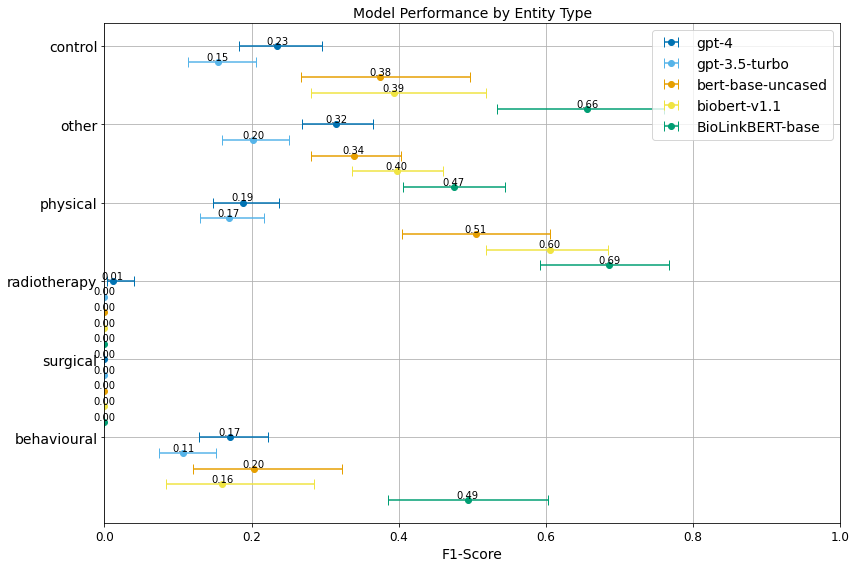

In [203]:
results = results_f1_majority
colors = {
    'bert-base-uncased': '#E69F00',
    'biobert-v1.1': '#F0E442',
    'BioLinkBERT-base': '#009E73',
    'gpt-3.5-turbo': '#56B4E9',
    'gpt-4': '#0072B2',
}


fig, ax = plt.subplots(figsize=(12, 8))

# Adjust spacing for readability
spacing = 0.2  # Spacing between models within the same entity type
entity_spacing = len(models) * spacing  # Total spacing to add per entity type

# List to keep track of legend handles and labels in order of appearance
legend_handles = []
legend_labels = []

# Iterate over each entity type and its corresponding data
for i, (entity_type, models) in enumerate(results.items()):
    model_offset = -entity_spacing / 2 + spacing / 2  # Start offset for the first model
    for model_name, data in models.items():
        # Data unpacking
        center = data[0][1]
        lower, upper = data[0][0], data[0][2]
        model_key = model_name.split('_')[1]
        color = colors[model_name.split('_')[1]]  # Extract model name part for color mapping
                    
        # Plot
        y_position = i + model_offset
        ax.errorbar(center, y_position, xerr=[[center - lower], [upper - center]], fmt='o', color=color, capsize=5, label=model_key)
        #ax.errorbar(center, y_position, xerr=[[center - lower], [upper - center]], fmt='o', capsize=5, color=color, label=model_name.split('_')[1])
        #if center == 0: 
        #    ax.text(center, y_position, f"{center:.2f}", ha='center', va='bottom')
        #else:
        #    ax.text(center, y_position, f"({lower:.2f}, {center:.2f}, {upper:.2f})", ha='center', va='bottom')
        ax.text(center, y_position, f"{center:.2f}", ha='center', va='bottom')
        model_offset += spacing  # Move the offset for the next model

# Adjust y-axis to accommodate the spread
ax.set_yticks(np.arange(len(results)) + entity_spacing / 2 - spacing / 2)
ax.set_yticklabels(results.keys(), fontsize=14)
ax.set_xlabel('F1-Score', fontsize=14)
ax.set_title('Model Performance by Entity Type', fontsize=14)
ax.grid(True)

ax.tick_params(axis='x', labelsize=12)
# Set x-axis limit to cap at 1
ax.set_xlim([0, 1])

# Legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(list(by_label.values())[::-1], list(by_label.keys())[::-1], loc='upper right', fontsize=14)

plt.tight_layout()
plt.show()


### add AACT

In [457]:
df_aact_labels_1 = pd.read_csv("../data/data_aact_sample/aact_neuro_random_sample_202307181034_annotated.csv")
df_aact_labels_2 = pd.read_csv("../data/data_aact_sample/aact_neuro_samples_second_batch_202309171159_annotated.csv")
df_aact_labels = pd.concat([df_aact_labels_1, df_aact_labels_2], ignore_index=True)
df_aact_labels.rename(columns={'conditions': 'aact_conditions'}, inplace=True)
df_aact_labels.rename(columns={'intervention_names': 'aact_intervention_names'}, inplace=True)
df_aact_labels.rename(columns={'intervention_types': 'aact_intervention_types'}, inplace=True)

# Function to replace values in aact_intervention_names based on aact_intervention_types
def replace_values(row):
    if 'Drug' not in row['aact_intervention_types']:
        return ""
    else:
        return row['aact_intervention_names']

# Apply the custom function to replace values in aact_intervention_names
df_aact_labels['aact_intervention_names'] = df_aact_labels.apply(replace_values, axis=1)
df_aact_labels['aact_intervention_names'] = df_aact_labels['aact_intervention_names'].str.replace('|Placebo|', '')
df_aact_labels['aact_intervention_names'] = df_aact_labels['aact_intervention_names'].str.replace('|Placebo', '')
df_aact_labels['aact_intervention_names'] = df_aact_labels['aact_intervention_names'].str.replace('Placebo|', '')

df_aact_labels.head(10)

/var/folders/px/wtj901jn7z9f26xgbys4l7jh0000gp/T/ipykernel_66708/392969139.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  df_aact_labels['aact_intervention_names'] = df_aact_labels['aact_intervention_names'].str.replace('|Placebo|', '')
/var/folders/px/wtj901jn7z9f26xgbys4l7jh0000gp/T/ipykernel_66708/392969139.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
  df_aact_labels['aact_intervention_names'] = df_aact_labels['aact_intervention_names'].str.replace('|Placebo', '')
/var/folders/px/wtj901jn7z9f26xgbys4l7jh0000gp/T/ipykernel_66708/392969139.py:19: FutureWarning: The default value of regex will change from True to False in a future version.
  df_aact_labels['aact_intervention_names'] = df_aact_labels['aact_intervention_names'].str.replace('Placebo|', '')


,nct_id,aact_conditions,aact_intervention_types,aact_intervention_names
0,NCT00000146,Multiple Sclerosis|Optic Neuritis,Drug,Methylprednisolone|Prednisone
1,NCT00001785,HTLV-I Infection|Spinal Cord Disease|Tropical ...,Drug,Recombinant human interferon beta-1a
2,NCT00029146,"Cerebral Infarction|Ischemic Attack, Transient...",Drug|Procedure,best medical therapy|extracranial-intracranial...
3,NCT00035815,Amyotrophic Lateral Sclerosis,Drug,"Insulin like growth factor, type 1|"
4,NCT00041717,Muscle Spasticity|Spinal Cord Injury,Drug|Other,Fampridine-SR|
5,NCT00053937,Neurofibromatosis Type 1|Precancerous Condition,Drug,pirfenidone
6,NCT00069550,Rett Syndrome,Drug,dextromethorphan|donepezil hydrochloride
7,NCT00081497,Fabry Disease,Biological,
8,NCT00099528,Neuralgia|Peripheral Nervous System Disease|Sh...,Drug,REN-1654
9,NCT00101933,Epilepsy,Device,


In [458]:
df_unique_labels_with_aact = pd.merge(df_unique_labels, df_aact_labels, on='nct_id', how='left')
df_unique_labels_with_aact.head()

,nct_id,unique_conditions_target,unique_interventions_target,unique_interventions_type_target,unique_conditions_BioLinkBERT-base_predictions,unique_interventions_BioLinkBERT-base_predictions,unique_interventions_type_BioLinkBERT-base_predictions,unique_conditions_bert-base-uncased_predictions,unique_interventions_bert-base-uncased_predictions,unique_interventions_type_bert-base-uncased_predictions,unique_conditions_biobert-v1.1_predictions,unique_interventions_biobert-v1.1_predictions,unique_interventions_type_biobert-v1.1_predictions,aact_conditions,aact_intervention_types,aact_intervention_names
0,NCT04849741,alexander disease|axd.,ion373,DRUG,alexander disease|axd,ion373,DRUG,alexander disease|axd,ion373,DRUG,alexander disease|axd,ion373,DRUG,Alexander Disease,Drug,ION373|
1,NCT04576507,chronic pain|pain,delta-9-tetrahydrocannabinol|cannabinoids|tetr...,DRUG,chronic pain|pain|hyperalgesia,cannabidi|cannabinoids|cannabidiol,DRUG,pain|chronic pain|abuse|experimental pain,cannabidiol|cannabinoids|tetrahydrocannabinol,DRUG,chronic pain|pain,cannabidiol|cannabino|canna,DRUG,Cannabis|Hyperalgesia|Pain|Tolerance,Drug,Cannabis
2,NCT00261508,pervasive developmental disorders|autistic dis...,antipsychotic medication|risperidone,DRUG,pervasive developmental disorders|autistic dis...,antipsychotic medication|risperidone,DRUG,per|pervasive developmental disorders|autistic...,risperidon|anti|risperidone,DRUG,pervasive developmental disorders|autistic dis...,antipsy,DRUG,Asperger Syndrome|Autistic Disorder|DCild Deve...,Drug,risperidone
3,NCT01495923,lumbosacral radicular pain|lumbosacral radicul...,gabapentin|steroid,DRUG,pain|lumbosacral radicular pain|lumbosacral ra...,gabapentin,DRUG,pain,epid|gabapentin|steroid,DRUG,pain|lumbosacral radicular pain|lumbosacral ra...,gabapentin,DRUG,Radiculopathy|Sciatica,Drug|Procedure,Gabapentin| gabapentin|Sham epidural steroid i...
4,NCT03150563,,,,,,,,,,,,,"Contracture of Muscle, Thigh|Muscle Rigidity|S...",Other,


### add GPT

In [459]:
prompt_version_to_evaluate = "v1"


In [460]:
if prompt_version_to_evaluate == "v2":
    gpt_file = "./predictions/ct_neuro_test_annotated_gpt-3.5-turbo_prompt_v2_20240129.csv"
else:
    gpt_file = "./predictions/ct_neuro_test_annotated_gpt-3.5-turbo_prompt_v1_20240129.csv"

In [461]:
gpt_file

'./predictions/ct_neuro_test_annotated_gpt-3.5-turbo_prompt_v1_20240129.csv'

In [462]:
df_gpt = pd.read_csv(gpt_file)
df_gpt.head(3)

,Unnamed: 0,nct_id,text,gpt-3.5-turbo_predictions_conditions,gpt-3.5-turbo_predictions_interventions
0,0,NCT04849741,"A Phase 1-3, Double-Blind, Randomized, Placebo...",Alexander Disease | none,ION373
1,1,NCT04576507,Effects of Repeated Cannabis Administration on...,Chronic pain|pain|hyperalgesia|analgesic|abuse...,cannabis|opioids|cannabinoids|delta-9-tetrahyd...
2,2,NCT00261508,Efficacy And Safety Of Risperidone In The Trea...,Autistic Disorder|Pervasive Developmental Diso...,risperidone|placebo


In [463]:
df_unique_labels = pd.merge(df_unique_labels_with_aact, df_gpt, on='nct_id', how='left')
df_unique_labels.shape

(90, 20)

In [464]:
gpt_model = 'gpt-4'

if prompt_version_to_evaluate == "v2":
    gpt4_file = "./predictions/ct_neuro_test_annotated_gpt-4_prompt_v2_20240129.csv"
else:
    gpt4_file = "./predictions/ct_neuro_test_annotated_gpt-4_prompt_v1_20240129.csv"
    
df_gpt_4 = pd.read_csv(gpt4_file)[['nct_id', 'gpt-4_predictions_conditions', 'gpt-4_predictions_interventions']]
df_gpt_4.head(3)

,nct_id,gpt-4_predictions_conditions,gpt-4_predictions_interventions
0,NCT04849741,Alexander Disease | gross motor function,ION373
1,NCT04576507,Chronic pain | pain | hyperalgesia | analgesic...,Cannabis|delta-9-tetrahydrocannabinol (THC)|ca...
2,NCT00261508,Autistic Disorder | Pervasive Developmental Di...,Risperidone


In [465]:
df_unique_labels = pd.merge(df_unique_labels, df_gpt_4, on='nct_id', how='left')
df_unique_labels.shape

(90, 22)

In [466]:
df_unique_labels.head(2)

,nct_id,unique_conditions_target,unique_interventions_target,unique_interventions_type_target,unique_conditions_BioLinkBERT-base_predictions,unique_interventions_BioLinkBERT-base_predictions,unique_interventions_type_BioLinkBERT-base_predictions,unique_conditions_bert-base-uncased_predictions,unique_interventions_bert-base-uncased_predictions,unique_interventions_type_bert-base-uncased_predictions,...,unique_interventions_type_biobert-v1.1_predictions,aact_conditions,aact_intervention_types,aact_intervention_names,Unnamed: 0,text,gpt-3.5-turbo_predictions_conditions,gpt-3.5-turbo_predictions_interventions,gpt-4_predictions_conditions,gpt-4_predictions_interventions
0,NCT04849741,alexander disease|axd.,ion373,DRUG,alexander disease|axd,ion373,DRUG,alexander disease|axd,ion373,DRUG,...,DRUG,Alexander Disease,Drug,ION373|,0,"A Phase 1-3, Double-Blind, Randomized, Placebo...",Alexander Disease | none,ION373,Alexander Disease | gross motor function,ION373
1,NCT04576507,chronic pain|pain,delta-9-tetrahydrocannabinol|cannabinoids|tetr...,DRUG,chronic pain|pain|hyperalgesia,cannabidi|cannabinoids|cannabidiol,DRUG,pain|chronic pain|abuse|experimental pain,cannabidiol|cannabinoids|tetrahydrocannabinol,DRUG,...,DRUG,Cannabis|Hyperalgesia|Pain|Tolerance,Drug,Cannabis,1,Effects of Repeated Cannabis Administration on...,Chronic pain|pain|hyperalgesia|analgesic|abuse...,cannabis|opioids|cannabinoids|delta-9-tetrahyd...,Chronic pain | pain | hyperalgesia | analgesic...,Cannabis|delta-9-tetrahydrocannabinol (THC)|ca...


## Conditions Evaluation

In [467]:
conditions_db = pd.read_csv("../data/neuro_diseases_terminology/output/diseases_dictionary_mesh_icd.csv")

In [468]:
def add_variant(canonical_name, variant, drug_variant_to_canonical):
    #print(drug_variant_to_canonical)
    if variant not in drug_variant_to_canonical:
        drug_variant_to_canonical[variant] = set()
    drug_variant_to_canonical[variant].add(canonical_name)
    return drug_variant_to_canonical

In [469]:
def generate_conditions_lookup_dictionary(df):
    synonyms_dict = {}
    
    for index, row in df.iterrows():
        icd_title = row['ICD Title']
        mesh_name = row['MeSH Common name']
        if pd.notna(row['MeSH Synonyms']):
            synonyms_list = row['MeSH Synonyms'].split('|')
            for synonym in synonyms_list:
                synonym = synonym.strip().lower()
                mesh_name = mesh_name.lower()
                synonyms_dict = add_variant(mesh_name, synonym, synonyms_dict)
        elif pd.notna(row['ICD Title']):
            icd_title = icd_title.lower()
            synonyms_dict = add_variant(icd_title, icd_title, synonyms_dict) 
        elif pd.notna(row['MeSH Common name']):
            mesh_nam = mesh_name.lower()
            synonyms_dict = add_variant(mesh_name, mesh_name, synonyms_dict)
    
    return synonyms_dict

In [470]:
synonyms_dict = generate_conditions_lookup_dictionary(conditions_db)

In [471]:
synonyms_dict.get("autism spectrum disorder")

{'autism spectrum disorder'}

In [472]:
synonyms_dict.get("autistic disorder")

In [473]:
import re
df_conditions = df_unique_labels[["nct_id", "unique_conditions_target", f'unique_conditions_{model_name_str_biolink}_predictions', 
                                  f'unique_conditions_{model_name_str_biobert}_predictions', f'unique_conditions_{model_name_str_bertbase}_predictions', "aact_conditions", "gpt-3.5-turbo_predictions_conditions", "gpt-4_predictions_conditions"]]
df_conditions.head(-5)

,nct_id,unique_conditions_target,unique_conditions_BioLinkBERT-base_predictions,unique_conditions_biobert-v1.1_predictions,unique_conditions_bert-base-uncased_predictions,aact_conditions,gpt-3.5-turbo_predictions_conditions,gpt-4_predictions_conditions
0,NCT04849741,alexander disease|axd.,alexander disease|axd,alexander disease|axd,alexander disease|axd,Alexander Disease,Alexander Disease | none,Alexander Disease | gross motor function
1,NCT04576507,chronic pain|pain,chronic pain|pain|hyperalgesia,chronic pain|pain,pain|chronic pain|abuse|experimental pain,Cannabis|Hyperalgesia|Pain|Tolerance,Chronic pain|pain|hyperalgesia|analgesic|abuse...,Chronic pain | pain | hyperalgesia | analgesic...
2,NCT00261508,pervasive developmental disorders|autistic dis...,pervasive developmental disorders|autistic dis...,pervasive developmental disorders|autistic dis...,per|pervasive developmental disorders|autistic...,Asperger Syndrome|Autistic Disorder|DCild Deve...,Autistic Disorder|Pervasive Developmental Diso...,Autistic Disorder | Pervasive Developmental Di...
3,NCT01495923,lumbosacral radicular pain|lumbosacral radicul...,pain|lumbosacral radicular pain|lumbosacral ra...,pain|lumbosacral radicular pain|lumbosacral ra...,pain,Radiculopathy|Sciatica,Lumbosacral radiculopathy | radicular pain | none,Lumbosacral Radiculopathy | Radicular Pain
4,NCT03150563,,,,,"Contracture of Muscle, Thigh|Muscle Rigidity|S...",none,none
...,...,...,...,...,...,...,...,...
80,NCT00909012,phenylketonuria,phenylketonuria,classical pku|phenylketonuria,phenylketonuria,Phenylketonuria,Phenylketonuria|inborn error in the metabolism...,Phenylketonuria levels | impaired neural func...
81,NCT04955249,delirium|hip fracture surgery,delirium|hip fracture surgery,delirium|hip fracture surgery,delirium|hip fracture surgery,Dexmedetomidine|Elderly|Hip Fracture Surgery|P...,Delirium|none,Hip Fracture Surgery | Delirium
82,NCT00252850,idiopathic parkinson's disease,idiopathic parkinson's disease,idiopathic parkinson's disease,idiopathic parkinson's disease,Parkinson's Disease,Parkinson's Disease | none,Idiopathic Parkinson's Disease
83,NCT02840643,hemiplegia|unilateral brain injury,hemiplegia|unilateral brain injury,unilateral brain injury,unilateral brain injury,Cerebral Palsy|Hemiplegia,Unilateral Brain Injury | hemiplegia therapy |...,Unilateral Brain Injury | Hemiplegia | less-af...


### Normalize representations

In [474]:
def lookup_canonical(conditions_list, synonyms_dict):
        canonical_list = []
        for condition in conditions_list.split('|'):
            condition = condition.lower().strip()
            if condition == "none" or condition == "" or condition == "none.":
                continue # generated by gpt if no condition was found
            if condition in synonyms_dict:
                canonical_list.extend(synonyms_dict[condition])
            else:
                canonical_list.append(condition)
        return '|'.join(canonical_list)

In [475]:
def process_dataframe(df, synonyms_dict):
    df.loc[:, 'canonical_unique_conditions'] = df['unique_conditions_target'].apply(lookup_canonical, synonyms_dict=synonyms_dict)
    df.loc[:, f'canonical_{model_name_str_bertbase}_conditions'] = df[f'unique_conditions_{model_name_str_bertbase}_predictions'].apply(lookup_canonical, synonyms_dict=synonyms_dict)
    df.loc[:, f'canonical_{model_name_str_biolink}_conditions'] = df[f'unique_conditions_{model_name_str_biolink}_predictions'].apply(lookup_canonical, synonyms_dict=synonyms_dict)
    df.loc[:, f'canonical_{model_name_str_biobert}_conditions'] = df[f'unique_conditions_{model_name_str_biobert}_predictions'].apply(lookup_canonical, synonyms_dict=synonyms_dict)
    df.loc[:, 'canonical_aact_conditions'] = df['aact_conditions'].apply(lookup_canonical, synonyms_dict=synonyms_dict)
    df.loc[:, 'canonical_gpt_conditions'] = df['gpt-3.5-turbo_predictions_conditions'].apply(lookup_canonical, synonyms_dict=synonyms_dict)
    df.loc[:, 'canonical_gpt-4_conditions'] = df['gpt-4_predictions_conditions'].apply(lookup_canonical, synonyms_dict=synonyms_dict)

    return df

In [476]:
df_conditions_mapped = process_dataframe(df_conditions, synonyms_dict)

/Users/donevas/opt/miniconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [477]:
df_conditions_mapped.head(2)

,nct_id,unique_conditions_target,unique_conditions_BioLinkBERT-base_predictions,unique_conditions_biobert-v1.1_predictions,unique_conditions_bert-base-uncased_predictions,aact_conditions,gpt-3.5-turbo_predictions_conditions,gpt-4_predictions_conditions,canonical_unique_conditions,canonical_bert-base-uncased_conditions,canonical_BioLinkBERT-base_conditions,canonical_biobert-v1.1_conditions,canonical_aact_conditions,canonical_gpt_conditions,canonical_gpt-4_conditions
0,NCT04849741,alexander disease|axd.,alexander disease|axd,alexander disease|axd,alexander disease|axd,Alexander Disease,Alexander Disease | none,Alexander Disease | gross motor function,alexander disease|axd.,alexander disease|axd,alexander disease|axd,alexander disease|axd,alexander disease,alexander disease,alexander disease|gross motor function
1,NCT04576507,chronic pain|pain,chronic pain|pain|hyperalgesia,chronic pain|pain,pain|chronic pain|abuse|experimental pain,Cannabis|Hyperalgesia|Pain|Tolerance,Chronic pain|pain|hyperalgesia|analgesic|abuse...,Chronic pain | pain | hyperalgesia | analgesic...,chronic pain|pain,pain|chronic pain|abuse|experimental pain,chronic pain|pain|hyperalgesia,chronic pain|pain,cannabis|hyperalgesia|pain|tolerance,chronic pain|pain|hyperalgesia|analgesic|abuse...,chronic pain|pain|hyperalgesia|analgesic effec...


In [377]:
#!pip install python-Levenshtein

In [378]:
#jaccard_similarity(string1, string2)

### Evaluation scripts

In [478]:
string1 = 'hemiplegic cerebral palsy|hcp'
string2 = 'cerebral palsy'
string3 = 'fibromyalgia'
string4 = 'juvenile primary fibromyalgia syndrome'

In [479]:
def exact_match(prediction, target):
    true_positive = 0
    false_positive = 0
    false_negative = 0

    for target_string in target:
        if target_string in prediction:
            true_positive += 1
        else:
            false_negative += 1

    for prediction_string in prediction:
        if prediction_string not in target:
            false_positive += 1

    return true_positive, false_positive, false_negative

# Example usage:
target = ["carbon-14 bia 28-6156", "bia 28-6156"]
prediction = ["bia 28-6156"]

tp, fp, fn = exact_match(prediction, target)
print("True Positives:", tp)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 1
False Positives: 0
False Negatives: 1


In [480]:
def majority_rule_match(prediction, target):
    true_positive = 0
    false_positive = 0
    false_negative = 0
    
    for target_string in target:
        target_words = target_string.split()
        matching_count = 0

        for prediction_string in prediction:
            prediction_words = prediction_string.split()
            common_words = set(target_words) & set(prediction_words)

            # Check if more than half of the words overlap
            if len(common_words) > len(target_words) / 2:
                matching_count += 1

        if matching_count > 0:
            true_positive += 1
        else:
            false_negative += 1

    for prediction_string in prediction:
        prediction_words = prediction_string.split()
        matching_count = 0

        for target_string in target:
            target_words = target_string.split()
            common_words = set(target_words) & set(prediction_words)

            # Check if more than half of the words overlap
            if len(common_words) > len(target_words) / 2:
                matching_count += 1

        if matching_count == 0:
            false_positive += 1

    return true_positive, false_positive, false_negative

# Example usage:
target = ["carbon-14 bia 28-6156", "bia 28-6156"]
prediction = ["bia 28-6156"]

tp, fp, fn = majority_rule_match(prediction, target)
print("True Positives:", tp)
print("False Positives:", fp)
print("False Negatives:", fn)


True Positives: 2
False Positives: 0
False Negatives: 0


In [481]:
def f1_score(precision, recall):
    if precision > 0 or recall > 0:
        f1 = 2 * ((precision * recall) / (precision + recall))
    else:
        f1 = 0
    return f1

def calculate_precision_recall_v2(prediction, target, method="exact_match", threshold=None):
    if len(set(prediction)) == 1 and len(set(target)) == 1 and list(set(prediction)) == list(set(target)) == ['']:
        return {"p": 0, "r": 0, "f1": 0}
    target_set = set([str(t).lower() for t in target])
    prediction_set = set([str(p).lower() for p in prediction])
    
    #print(prediction_set, target_set)
    
    if method == "exact_match":
        tp, fp, fn = exact_match(list(prediction_set), list(target_set))
    else:
        tp, fp, fn = majority_rule_match(list(prediction_set), list(target_set))
    #print(tp,fp,fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = f1_score(precision, recall)
 
    return {"p":round(precision,2), "r":round(recall,2), "f1":round(f1,2)}

def calculate_tp_fp_fn(prediction, target, method="exact_match", threshold=None):
    if len(set(prediction)) == 1 and len(set(target)) == 1 and list(set(prediction)) == list(set(target)) == ['']:
        return {"tp": 0, "fp": 0, "fn": 0}
    target_set = set([str(t).lower() for t in target])
    prediction_set = set([str(p).lower() for p in prediction])
    
    #print(prediction_set, target_set)
    
    if method == "exact_match":
        tp, fp, fn = exact_match(list(prediction_set), list(target_set))
    else:
        tp, fp, fn = majority_rule_match(list(prediction_set), list(target_set))
 
    return {"tp":round(tp,2), "fp":round(fp,2), "fn":round(fn,2)}

### tests

In [482]:
string1 = 'hemiplegic cerebral palsy|hcp'
string2 = 'cerebral palsy'
tp, fp, fn = majority_rule_match(string2.split("|"), string1.split("|"))
print("True Positives:", tp)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 1
False Positives: 0
False Negatives: 1


In [483]:
target = "carbon-14 bia 28-6156|bia 28-6156"
prediction = "bia 28-6156"
calculate_precision_recall_v2(prediction.split("|"), target.split("|"), method = "majority")

{'p': 1.0, 'r': 1.0, 'f1': 1.0}

### Evaluation

In [484]:
df_conditions_eval = df_conditions_mapped[['nct_id','canonical_unique_conditions','canonical_aact_conditions', f'canonical_{model_name_str_bertbase}_conditions', f'canonical_{model_name_str_biolink}_conditions', f'canonical_{model_name_str_biobert}_conditions', "canonical_gpt_conditions", "canonical_gpt-4_conditions"]]

In [485]:
df_conditions_eval.head(3)

,nct_id,canonical_unique_conditions,canonical_aact_conditions,canonical_bert-base-uncased_conditions,canonical_BioLinkBERT-base_conditions,canonical_biobert-v1.1_conditions,canonical_gpt_conditions,canonical_gpt-4_conditions
0,NCT04849741,alexander disease|axd.,alexander disease,alexander disease|axd,alexander disease|axd,alexander disease|axd,alexander disease,alexander disease|gross motor function
1,NCT04576507,chronic pain|pain,cannabis|hyperalgesia|pain|tolerance,pain|chronic pain|abuse|experimental pain,chronic pain|pain|hyperalgesia,chronic pain|pain,chronic pain|pain|hyperalgesia|analgesic|abuse...,chronic pain|pain|hyperalgesia|analgesic effec...
2,NCT00261508,pervasive developmental disorders|autistic dis...,asperger syndrome|autistic disorder|dcild deve...,per|pervasive developmental disorders|autistic...,pervasive developmental disorders|autistic dis...,pervasive developmental disorders|autistic dis...,autistic disorder|pervasive developmental diso...,autistic disorder|pervasive developmental diso...


In [486]:
methods = ["exact_match", "majority"] #, "majority", "levenshtein", "at_least_one", "at_least_one_overall"
col_names_to_eval = [f'canonical_{model_name_str_bertbase}_conditions', f'canonical_{model_name_str_biolink}_conditions', f'canonical_{model_name_str_biobert}_conditions', "canonical_gpt_conditions", 'canonical_gpt-4_conditions', 'canonical_aact_conditions']

for method in methods:
    for col_to_eval in col_names_to_eval:
        model = col_to_eval.split("_")[1]
        print(f"*** Eval {model} {method}***")
        column_name = f"eval_{method}_{model}"
        column_name_basic_metrics = f"eval_{method}_{model}_tp_fp_fn"
        df_conditions_eval[column_name] =  df_conditions_eval.apply(lambda row: calculate_precision_recall_v2(row[col_to_eval].split("|"), row["canonical_unique_conditions"].split("|"), method=method, threshold=0.5), axis=1)
        df_conditions_eval[column_name_basic_metrics] =  df_conditions_eval.apply(lambda row: calculate_tp_fp_fn(row[col_to_eval].split("|"), row["canonical_unique_conditions"].split("|"), method=method, threshold=0.5), axis=1)  

*** Eval bert-base-uncased exact_match***
*** Eval BioLinkBERT-base exact_match***
*** Eval biobert-v1.1 exact_match***
*** Eval gpt exact_match***
*** Eval gpt-4 exact_match***
*** Eval aact exact_match***
*** Eval bert-base-uncased majority***
*** Eval BioLinkBERT-base majority***
*** Eval biobert-v1.1 majority***
*** Eval gpt majority***
*** Eval gpt-4 majority***
*** Eval aact majority***


/var/folders/px/wtj901jn7z9f26xgbys4l7jh0000gp/T/ipykernel_66708/573266303.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_conditions_eval[column_name] =  df_conditions_eval.apply(lambda row: calculate_precision_recall_v2(row[col_to_eval].split("|"), row["canonical_unique_conditions"].split("|"), method=method, threshold=0.5), axis=1)
/var/folders/px/wtj901jn7z9f26xgbys4l7jh0000gp/T/ipykernel_66708/573266303.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_conditions_eval[column_name_basic_me

In [487]:
import numpy as np
# Replace empty strings with NaN in column 'A'
df_conditions_eval['canonical_unique_conditions'] = df_conditions_eval['canonical_unique_conditions'].replace('', np.nan)
df_conditions_eval['canonical_bert-base-uncased_conditions'] = df_conditions_eval['canonical_bert-base-uncased_conditions'].replace('', np.nan)
df_conditions_eval['canonical_BioLinkBERT-base_conditions'] = df_conditions_eval['canonical_BioLinkBERT-base_conditions'].replace('', np.nan)
df_conditions_eval['canonical_biobert-v1.1_conditions'] = df_conditions_eval['canonical_biobert-v1.1_conditions'].replace('', np.nan)
df_conditions_eval['canonical_aact_conditions'] = df_conditions_eval['canonical_aact_conditions'].replace('', np.nan)
df_conditions_eval['canonical_gpt_conditions'] = df_conditions_eval['canonical_gpt_conditions'].replace('', np.nan)
df_conditions_eval['canonical_gpt-4_conditions'] = df_conditions_eval['canonical_gpt-4_conditions'].replace('', np.nan)

len(df_conditions_eval)

90

In [488]:
df_conditions_eval.head(2)

,nct_id,canonical_unique_conditions,canonical_aact_conditions,canonical_bert-base-uncased_conditions,canonical_BioLinkBERT-base_conditions,canonical_biobert-v1.1_conditions,canonical_gpt_conditions,canonical_gpt-4_conditions,eval_exact_match_bert-base-uncased,eval_exact_match_bert-base-uncased_tp_fp_fn,...,eval_majority_BioLinkBERT-base,eval_majority_BioLinkBERT-base_tp_fp_fn,eval_majority_biobert-v1.1,eval_majority_biobert-v1.1_tp_fp_fn,eval_majority_gpt,eval_majority_gpt_tp_fp_fn,eval_majority_gpt-4,eval_majority_gpt-4_tp_fp_fn,eval_majority_aact,eval_majority_aact_tp_fp_fn
0,NCT04849741,alexander disease|axd.,alexander disease,alexander disease|axd,alexander disease|axd,alexander disease|axd,alexander disease,alexander disease|gross motor function,"{'p': 0.5, 'r': 0.5, 'f1': 0.5}","{'tp': 1, 'fp': 1, 'fn': 1}",...,"{'p': 0.5, 'r': 0.5, 'f1': 0.5}","{'tp': 1, 'fp': 1, 'fn': 1}","{'p': 0.5, 'r': 0.5, 'f1': 0.5}","{'tp': 1, 'fp': 1, 'fn': 1}","{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}","{'p': 0.5, 'r': 0.5, 'f1': 0.5}","{'tp': 1, 'fp': 1, 'fn': 1}","{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}"
1,NCT04576507,chronic pain|pain,cannabis|hyperalgesia|pain|tolerance,pain|chronic pain|abuse|experimental pain,chronic pain|pain|hyperalgesia,chronic pain|pain,chronic pain|pain|hyperalgesia|analgesic|abuse...,chronic pain|pain|hyperalgesia|analgesic effec...,"{'p': 0.5, 'r': 1.0, 'f1': 0.67}","{'tp': 2, 'fp': 2, 'fn': 0}",...,"{'p': 0.67, 'r': 1.0, 'f1': 0.8}","{'tp': 2, 'fp': 1, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 2, 'fp': 0, 'fn': 0}","{'p': 0.29, 'r': 1.0, 'f1': 0.44}","{'tp': 2, 'fp': 5, 'fn': 0}","{'p': 0.5, 'r': 1.0, 'f1': 0.67}","{'tp': 2, 'fp': 2, 'fn': 0}","{'p': 0.25, 'r': 0.5, 'f1': 0.33}","{'tp': 1, 'fp': 3, 'fn': 1}"


In [489]:
# IGNORE TRUE NEGATIVES - where no annotations in target or model
application="conditions"
eval_column_name="canonical_biobert-v1.1_conditions"
columns_to_check = [f'canonical_unique_{application}', eval_column_name]
df_without_tn = df_conditions_eval.dropna(subset=columns_to_check, how='all')
len(df_without_tn)

85

In [490]:
df_conditions_eval.to_csv(f"./evaluations/evaluated_ct_level_conditions_gpt_prompt_{prompt_version_to_evaluate}.csv")
#df_conditions_eval

In [491]:
df_conditions_eval.head(2)

,nct_id,canonical_unique_conditions,canonical_aact_conditions,canonical_bert-base-uncased_conditions,canonical_BioLinkBERT-base_conditions,canonical_biobert-v1.1_conditions,canonical_gpt_conditions,canonical_gpt-4_conditions,eval_exact_match_bert-base-uncased,eval_exact_match_bert-base-uncased_tp_fp_fn,...,eval_majority_BioLinkBERT-base,eval_majority_BioLinkBERT-base_tp_fp_fn,eval_majority_biobert-v1.1,eval_majority_biobert-v1.1_tp_fp_fn,eval_majority_gpt,eval_majority_gpt_tp_fp_fn,eval_majority_gpt-4,eval_majority_gpt-4_tp_fp_fn,eval_majority_aact,eval_majority_aact_tp_fp_fn
0,NCT04849741,alexander disease|axd.,alexander disease,alexander disease|axd,alexander disease|axd,alexander disease|axd,alexander disease,alexander disease|gross motor function,"{'p': 0.5, 'r': 0.5, 'f1': 0.5}","{'tp': 1, 'fp': 1, 'fn': 1}",...,"{'p': 0.5, 'r': 0.5, 'f1': 0.5}","{'tp': 1, 'fp': 1, 'fn': 1}","{'p': 0.5, 'r': 0.5, 'f1': 0.5}","{'tp': 1, 'fp': 1, 'fn': 1}","{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}","{'p': 0.5, 'r': 0.5, 'f1': 0.5}","{'tp': 1, 'fp': 1, 'fn': 1}","{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}"
1,NCT04576507,chronic pain|pain,cannabis|hyperalgesia|pain|tolerance,pain|chronic pain|abuse|experimental pain,chronic pain|pain|hyperalgesia,chronic pain|pain,chronic pain|pain|hyperalgesia|analgesic|abuse...,chronic pain|pain|hyperalgesia|analgesic effec...,"{'p': 0.5, 'r': 1.0, 'f1': 0.67}","{'tp': 2, 'fp': 2, 'fn': 0}",...,"{'p': 0.67, 'r': 1.0, 'f1': 0.8}","{'tp': 2, 'fp': 1, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 2, 'fp': 0, 'fn': 0}","{'p': 0.29, 'r': 1.0, 'f1': 0.44}","{'tp': 2, 'fp': 5, 'fn': 0}","{'p': 0.5, 'r': 1.0, 'f1': 0.67}","{'tp': 2, 'fp': 2, 'fn': 0}","{'p': 0.25, 'r': 0.5, 'f1': 0.33}","{'tp': 1, 'fp': 3, 'fn': 1}"


In [492]:
#df_conditions_eval["eval_exact_match_BioLinkBERT-base_tp_fp_fn"] = df_conditions_eval["eval_exact_match_BioLinkBERT-base_tp_fp_fn"].apply(ast.literal_eval)
tp_sum = df_conditions_eval["eval_exact_match_BioLinkBERT-base_tp_fp_fn"].apply(lambda x: x['tp']).sum()
fp_sum = df_conditions_eval["eval_exact_match_BioLinkBERT-base_tp_fp_fn"].apply(lambda x: x['fp']).sum()
fn_sum = df_conditions_eval["eval_exact_match_BioLinkBERT-base_tp_fp_fn"].apply(lambda x: x['fn']).sum()

In [493]:
tp_sum, fp_sum, fn_sum, tp_sum + fp_sum + fn_sum

(200, 73, 43, 316)

In [494]:
tp_sum = df_conditions_eval["eval_exact_match_biobert-v1.1_tp_fp_fn"].apply(lambda x: x['tp']).sum()
fp_sum = df_conditions_eval["eval_exact_match_biobert-v1.1_tp_fp_fn"].apply(lambda x: x['fp']).sum()
fn_sum = df_conditions_eval["eval_exact_match_biobert-v1.1_tp_fp_fn"].apply(lambda x: x['fn']).sum()

In [495]:
tp_sum, fp_sum, fn_sum, tp_sum + fp_sum + fn_sum

(185, 81, 58, 324)

In [496]:
tp_sum = df_conditions_eval["eval_exact_match_bert-base-uncased_tp_fp_fn"].apply(lambda x: x['tp']).sum()
fp_sum = df_conditions_eval["eval_exact_match_bert-base-uncased_tp_fp_fn"].apply(lambda x: x['fp']).sum()
fn_sum = df_conditions_eval["eval_exact_match_bert-base-uncased_tp_fp_fn"].apply(lambda x: x['fn']).sum()

In [497]:
tp_sum, fp_sum, fn_sum, tp_sum + fp_sum + fn_sum

(154, 79, 90, 323)

In [498]:
from scipy.stats import norm

In [499]:
def wilson_score_interval(tp, fp, fn, metric):
    confidence=0.95
    x = tp
    if metric == "precision":
        n = tp + fp
    elif metric == "recall":
        n = tp + fn
    elif metric == "f1":
        x = 2 * tp
        n = 2 * tp + fp + fn
    else:
        return (0, 0)

    z = norm.ppf(1 - (1 - confidence) / 2)
    phat = x / n
    center = (x + z ** 2 / 2) / (n + z ** 2)

    interval = ((z * np.sqrt(n)) / (n + z ** 2)) * np.sqrt(phat * (1 - phat) + z ** 2 / (4 * n))

    lower_bound = center - interval
    upper_bound = center + interval
    return round(lower_bound,3), round(phat,3), round(upper_bound,3)

In [500]:
def plot_confidence_interval(x, values, z=1.96, color='#2187bb', horizontal_line_width=0.25):
    mean = values[1]
    top = values[2]
    bottom = values[0]

    left = x - horizontal_line_width / 2
    right = x + horizontal_line_width / 2
    
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, mean, 'o', color='black')
    plt.xlabel('NER Method', fontsize=12)  # Add x-axis label
    plt.ylabel('F1-Score', fontsize=12)    # Add y-axis label
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    #plt.text(x, mean, f'{mean:.2f}', ha='left', va='bottom', color='black', fontsize=12)  # Add value


In [501]:
col_names_to_eval

['canonical_bert-base-uncased_conditions',
 'canonical_BioLinkBERT-base_conditions',
 'canonical_biobert-v1.1_conditions',
 'canonical_gpt_conditions',
 'canonical_gpt-4_conditions',
 'canonical_aact_conditions']

In [502]:
condition_results_f1_exact = {}
condition_results_f1_majority = {}

for method in methods:
    print()
    for col_to_eval in col_names_to_eval:
        model = col_to_eval.split("_")[1]
        column_name = f"eval_{method}_{model}_tp_fp_fn"
        print(f"*** {column_name} ***")
        tp_sum = df_conditions_eval[column_name].apply(lambda x: x['tp']).sum()
        fp_sum = df_conditions_eval[column_name].apply(lambda x: x['fp']).sum()
        fn_sum = df_conditions_eval[column_name].apply(lambda x: x['fn']).sum()
        print("* F1 *")
        result = wilson_score_interval(tp_sum, fp_sum, fn_sum, "f1")
        if "exact" in method:
            condition_results_f1_exact[model] = result
        else:
            condition_results_f1_majority[model] = result
        print(result)
        #print("* P *")
        #print(wilson_score_interval(tp_sum, fp_sum, fn_sum, "precision"))
        #print("* R *")
        #print(wilson_score_interval(tp_sum, fp_sum, fn_sum, "recall"))


*** eval_exact_match_bert-base-uncased_tp_fp_fn ***
* F1 *
(0.602, 0.646, 0.687)
*** eval_exact_match_BioLinkBERT-base_tp_fp_fn ***
* F1 *
(0.737, 0.775, 0.809)
*** eval_exact_match_biobert-v1.1_tp_fp_fn ***
* F1 *
(0.687, 0.727, 0.764)
*** eval_exact_match_gpt_tp_fp_fn ***
* F1 *
(0.361, 0.397, 0.434)
*** eval_exact_match_gpt-4_tp_fp_fn ***
* F1 *
(0.45, 0.492, 0.533)
*** eval_exact_match_aact_tp_fp_fn ***
* F1 *
(0.3, 0.342, 0.387)

*** eval_majority_bert-base-uncased_tp_fp_fn ***
* F1 *
(0.65, 0.693, 0.733)
*** eval_majority_BioLinkBERT-base_tp_fp_fn ***
* F1 *
(0.793, 0.828, 0.858)
*** eval_majority_biobert-v1.1_tp_fp_fn ***
* F1 *
(0.757, 0.794, 0.827)
*** eval_majority_gpt_tp_fp_fn ***
* F1 *
(0.448, 0.485, 0.523)
*** eval_majority_gpt-4_tp_fp_fn ***
* F1 *
(0.572, 0.612, 0.652)
*** eval_majority_aact_tp_fp_fn ***
* F1 *
(0.383, 0.428, 0.474)


In [503]:
condition_results_f1_majority

{'bert-base-uncased': (0.65, 0.693, 0.733),
 'BioLinkBERT-base': (0.793, 0.828, 0.858),
 'biobert-v1.1': (0.757, 0.794, 0.827),
 'gpt': (0.448, 0.485, 0.523),
 'gpt-4': (0.572, 0.612, 0.652),
 'aact': (0.383, 0.428, 0.474)}

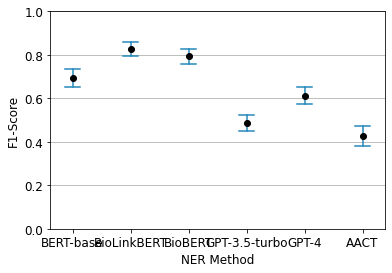

In [505]:
import matplotlib.pyplot as plt

model_names = ['BERT-base','BioLinkBERT', 'BioBERT', 'GPT-3.5-turbo', 'GPT-4', 'AACT']

bertbase = condition_results_f1_majority['bert-base-uncased']
biolinkbert = condition_results_f1_majority['BioLinkBERT-base']
biobert = condition_results_f1_majority['biobert-v1.1']
gpt = condition_results_f1_majority['gpt']
gpt_4 = condition_results_f1_majority['gpt-4']
aact = condition_results_f1_majority['aact']

plt.xticks([1, 2, 3, 4, 5, 6], model_names, fontsize=12)
#plt.title('Performance For CONDITION Recognition')
plot_confidence_interval(1, bertbase)
plot_confidence_interval(2, biolinkbert)
plot_confidence_interval(3, biobert)
plot_confidence_interval(4, gpt)
plot_confidence_interval(5, gpt_4)
plot_confidence_interval(6, aact)
plt.grid(axis='y')  # Show only horizontal grid lines
plt.ylim(0, 1) #
plt.savefig(f'./evaluations/plots/abstract_level_majority_plot_with_CI_CONDITION_20240129_ptompt_{prompt_version_to_evaluate}.png')

In [506]:
df_conditions_eval.head(2)

,nct_id,canonical_unique_conditions,canonical_aact_conditions,canonical_bert-base-uncased_conditions,canonical_BioLinkBERT-base_conditions,canonical_biobert-v1.1_conditions,canonical_gpt_conditions,canonical_gpt-4_conditions,eval_exact_match_bert-base-uncased,eval_exact_match_bert-base-uncased_tp_fp_fn,...,eval_majority_BioLinkBERT-base,eval_majority_BioLinkBERT-base_tp_fp_fn,eval_majority_biobert-v1.1,eval_majority_biobert-v1.1_tp_fp_fn,eval_majority_gpt,eval_majority_gpt_tp_fp_fn,eval_majority_gpt-4,eval_majority_gpt-4_tp_fp_fn,eval_majority_aact,eval_majority_aact_tp_fp_fn
0,NCT04849741,alexander disease|axd.,alexander disease,alexander disease|axd,alexander disease|axd,alexander disease|axd,alexander disease,alexander disease|gross motor function,"{'p': 0.5, 'r': 0.5, 'f1': 0.5}","{'tp': 1, 'fp': 1, 'fn': 1}",...,"{'p': 0.5, 'r': 0.5, 'f1': 0.5}","{'tp': 1, 'fp': 1, 'fn': 1}","{'p': 0.5, 'r': 0.5, 'f1': 0.5}","{'tp': 1, 'fp': 1, 'fn': 1}","{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}","{'p': 0.5, 'r': 0.5, 'f1': 0.5}","{'tp': 1, 'fp': 1, 'fn': 1}","{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}"
1,NCT04576507,chronic pain|pain,cannabis|hyperalgesia|pain|tolerance,pain|chronic pain|abuse|experimental pain,chronic pain|pain|hyperalgesia,chronic pain|pain,chronic pain|pain|hyperalgesia|analgesic|abuse...,chronic pain|pain|hyperalgesia|analgesic effec...,"{'p': 0.5, 'r': 1.0, 'f1': 0.67}","{'tp': 2, 'fp': 2, 'fn': 0}",...,"{'p': 0.67, 'r': 1.0, 'f1': 0.8}","{'tp': 2, 'fp': 1, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 2, 'fp': 0, 'fn': 0}","{'p': 0.29, 'r': 1.0, 'f1': 0.44}","{'tp': 2, 'fp': 5, 'fn': 0}","{'p': 0.5, 'r': 1.0, 'f1': 0.67}","{'tp': 2, 'fp': 2, 'fn': 0}","{'p': 0.25, 'r': 0.5, 'f1': 0.33}","{'tp': 1, 'fp': 3, 'fn': 1}"


In [507]:
def calculate_mean_scores(df, eval_column_name, model_name, application="conditions"):
    # IGNORE TRUE NEGATIVES
    columns_to_check = [f'canonical_unique_{application}', f'canonical_{model_name}_{application}']
    df_without_tn = df.dropna(subset=columns_to_check, how='all')
    print("Evaluated rows: ", len(df_without_tn))
    
    mean_p = df_without_tn[eval_column_name].apply(lambda x: x['p']).mean()
    mean_r = df_without_tn[eval_column_name].apply(lambda x: x['r']).mean()
    mean_f1 = df_without_tn[eval_column_name].apply(lambda x: x['f1']).mean()
    print(f"Mean p {model_name}:", round(mean_p, 3))
    print(f"Mean r {model_name}:", round(mean_r, 3))
    print(f"Mean f1 {model_name}:", round(mean_f1, 3))

In [508]:
for method in methods:
    print()
    for col_to_eval in col_names_to_eval:
        model = col_to_eval.split("_")[1]
        column_name = f"eval_{method}_{model}"
        print(f"*** {column_name} ***")
        calculate_mean_scores(df_conditions_eval, column_name, model)


*** eval_exact_match_bert-base-uncased ***
Evaluated rows:  86
Mean p bert-base-uncased: 0.73
Mean r bert-base-uncased: 0.707
Mean f1 bert-base-uncased: 0.694
*** eval_exact_match_BioLinkBERT-base ***
Evaluated rows:  85
Mean p BioLinkBERT-base: 0.8
Mean r BioLinkBERT-base: 0.846
Mean f1 BioLinkBERT-base: 0.806
*** eval_exact_match_biobert-v1.1 ***
Evaluated rows:  85
Mean p biobert-v1.1: 0.781
Mean r biobert-v1.1: 0.793
Mean f1 biobert-v1.1: 0.766
*** eval_exact_match_gpt ***
Evaluated rows:  87
Mean p gpt: 0.549
Mean r gpt: 0.598
Mean f1 gpt: 0.511
*** eval_exact_match_gpt-4 ***
Evaluated rows:  85
Mean p gpt-4: 0.571
Mean r gpt-4: 0.63
Mean f1 gpt-4: 0.555
*** eval_exact_match_aact ***
Evaluated rows:  90
Mean p aact: 0.531
Mean r aact: 0.352
Mean f1 aact: 0.389

*** eval_majority_bert-base-uncased ***
Evaluated rows:  86
Mean p bert-base-uncased: 0.763
Mean r bert-base-uncased: 0.733
Mean f1 bert-base-uncased: 0.725
*** eval_majority_BioLinkBERT-base ***
Evaluated rows:  85
Mean p

## Drugs Evaluation

In [509]:
import csv
import re

### Normalize representations

In [510]:
path_prefix = "../data"

In [511]:
variant_regex = re.compile(r'^[A-Za-z0-9,]+[ -]?[A-Za-z0-9\-]+(?:[ -][A-Z])?$')
drug_variant_to_canonical = {}
drug_canonical_to_data = {}

def add_variant(canonical_name, variant):
    if variant not in drug_variant_to_canonical:
        drug_variant_to_canonical[variant] = set()
    drug_variant_to_canonical[variant].add(canonical_name)


def add_drug(id, synonyms):
    synonyms = [s.strip() for s in synonyms]

    #TODO: add using an exclusion list as a parameter option to the function
    #if re.sub("[- ].+", "", synonyms[0].upper()) in exclusions:
    #    return
    if not variant_regex.match(synonyms[0]):
        return
    if synonyms[0] not in drug_canonical_to_data:
        drug_canonical_to_data[synonyms[0]] = {"name": synonyms[0], "synonyms": set()}
    if id.startswith("a"):
        drug_canonical_to_data[synonyms[0]]["medline_plus_id"] = id
    elif id.startswith("https://www.nhs.uk"):
        drug_canonical_to_data[synonyms[0]]["nhs_url"] = id
    elif id.startswith("https://en.wikipedia"):
        drug_canonical_to_data[synonyms[0]]["wikipedia_url"] = id
    elif id.startswith("DB"):
        drug_canonical_to_data[synonyms[0]]["drugbank_id"] = id
    else:
        drug_canonical_to_data[synonyms[0]]["mesh_id"] = id
    for variant in synonyms:
        #if re.sub(" .+", "", variant.upper()) in exclusions:
        #    return
        if variant_regex.match(variant):
            drug_canonical_to_data[synonyms[0]]["synonyms"].add(variant)
            add_variant(synonyms[0], variant.lower())
            #add_variant(synonyms[0], variant)
            #add_variant(synonyms[0], variant.upper())
            #if variant.lower() in words_to_allow_lower_case:    

with open(path_prefix + "/drug_names_terminology/drugs_dictionary_medlineplus.csv", 'r', encoding="utf-8") as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    headers = None
    for row in spamreader:
        if not headers:
            headers = row
            continue
        id = row[0]
        name = row[1]
        synonyms = row[2].split(r"|")
        name = re.sub(
            " (Injection|Oral Inhalation|Transdermal|Ophthalmic|Topical|Vaginal Cream|Nasal Spray|Transdermal Patch|Rectal)",
            "", name)
        name = name.lower()
        if name == "abobotulinumtoxina":
            print(row[1], synonyms)

        add_drug(id, [name] + synonyms)

AbobotulinumtoxinA Injection ['Dysport', 'BoNT-A']


In [512]:

with open(path_prefix + "/drug_names_terminology/drugs_dictionary_nhs.csv", 'r', encoding="utf-8") as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    headers = None
    for row in spamreader:
        if not headers:
            headers = row
            continue
        id = row[0]
        name = row[1]
        synonyms = row[2].split(r"|")
        name = name.lower()
        add_drug(id, [name] + synonyms)


with open(path_prefix + "/drug_names_terminology/drugs_dictionary_wikipedia.csv", 'r', encoding="utf-8") as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    headers = None
    for row in spamreader:
        if not headers:
            headers = row
            continue
        id = row[0]
        name = row[1]
        synonyms = row[2].split(r"|")
        name = name.lower()
        add_drug(id, [name] + synonyms)
        
with open(path_prefix + "/drug_names_terminology/drugs_dictionary_mesh.csv", 'r', encoding="utf-8") as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    headers = None
    for row in spamreader:
        if not headers:
            headers = row
            continue
        id = row[0]
        name = row[1]
        synonyms = row[2].split(r"\|")
        name = name.lower()
        add_drug(id, [name] + synonyms)

# adding for the full db with product names included as synonyms
# TODO: create a parametrized function from this, not hard-coded inline as it is
is_new_format = False
if is_new_format:
    with open(path_prefix + "/drug_names_terminology/drugdb_full_database_parsed.csv", 'r', encoding="utf-8") as csvfile:
        spamreader = csv.reader(csvfile, delimiter=';')
        headers = None
        for row in spamreader:
            #print(row)
            if not headers:
                headers = row
                continue
            id = row[0]
            name = row[1]
            synonyms = row[4].split(r"|")
            products = row[5].split(r"|")
            syn_prod = synonyms + products
            name = name.lower()
            add_drug(id, [name] + syn_prod)
# no product names considered
else:
    with open(path_prefix + "/drug_names_terminology/drugbank vocabulary.csv", 'r', encoding="utf-8") as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        headers = None
        for row in spamreader:
            if not headers:
                headers = row
                continue
            id = row[0]
            name = row[2]
            synonyms = row[5].split(r"|")
            name = name.lower()
            add_drug(id, [name] + synonyms)

In [513]:
drug_variant_to_canonical.get("exelon")

{'rivastigmine', 'rivastigmine patch'}

In [514]:
df_unique_labels.head(-5)

,nct_id,unique_conditions_target,unique_interventions_target,unique_interventions_type_target,unique_conditions_BioLinkBERT-base_predictions,unique_interventions_BioLinkBERT-base_predictions,unique_interventions_type_BioLinkBERT-base_predictions,unique_conditions_bert-base-uncased_predictions,unique_interventions_bert-base-uncased_predictions,unique_interventions_type_bert-base-uncased_predictions,...,unique_interventions_type_biobert-v1.1_predictions,aact_conditions,aact_intervention_types,aact_intervention_names,Unnamed: 0,text,gpt-3.5-turbo_predictions_conditions,gpt-3.5-turbo_predictions_interventions,gpt-4_predictions_conditions,gpt-4_predictions_interventions
0,NCT04849741,alexander disease|axd.,ion373,DRUG,alexander disease|axd,ion373,DRUG,alexander disease|axd,ion373,DRUG,...,DRUG,Alexander Disease,Drug,ION373|,0,"A Phase 1-3, Double-Blind, Randomized, Placebo...",Alexander Disease | none,ION373,Alexander Disease | gross motor function,ION373
1,NCT04576507,chronic pain|pain,delta-9-tetrahydrocannabinol|cannabinoids|tetr...,DRUG,chronic pain|pain|hyperalgesia,cannabidi|cannabinoids|cannabidiol,DRUG,pain|chronic pain|abuse|experimental pain,cannabidiol|cannabinoids|tetrahydrocannabinol,DRUG,...,DRUG,Cannabis|Hyperalgesia|Pain|Tolerance,Drug,Cannabis,1,Effects of Repeated Cannabis Administration on...,Chronic pain|pain|hyperalgesia|analgesic|abuse...,cannabis|opioids|cannabinoids|delta-9-tetrahyd...,Chronic pain | pain | hyperalgesia | analgesic...,Cannabis|delta-9-tetrahydrocannabinol (THC)|ca...
2,NCT00261508,pervasive developmental disorders|autistic dis...,antipsychotic medication|risperidone,DRUG,pervasive developmental disorders|autistic dis...,antipsychotic medication|risperidone,DRUG,per|pervasive developmental disorders|autistic...,risperidon|anti|risperidone,DRUG,...,DRUG,Asperger Syndrome|Autistic Disorder|DCild Deve...,Drug,risperidone,2,Efficacy And Safety Of Risperidone In The Trea...,Autistic Disorder|Pervasive Developmental Diso...,risperidone|placebo,Autistic Disorder | Pervasive Developmental Di...,Risperidone
3,NCT01495923,lumbosacral radicular pain|lumbosacral radicul...,gabapentin|steroid,DRUG,pain|lumbosacral radicular pain|lumbosacral ra...,gabapentin,DRUG,pain,epid|gabapentin|steroid,DRUG,...,DRUG,Radiculopathy|Sciatica,Drug|Procedure,Gabapentin| gabapentin|Sham epidural steroid i...,3,"Randomized, Double-blind, Comparative-effectiv...",Lumbosacral radiculopathy | radicular pain | none,Epidural Steroid Injections | Gabapentin,Lumbosacral Radiculopathy | Radicular Pain,Epidural Steroid Injections|Gabapentin
4,NCT03150563,,,,,,,,,,...,,"Contracture of Muscle, Thigh|Muscle Rigidity|S...",Other,,4,Effects of Different Intensities of Passive St...,none,none,none,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,NCT00909012,phenylketonuria,docosahexaenoic acid,DRUG,phenylketonuria,fish oil|docosahexaenoic acid,DRUG,phenylketonuria,fish|docosahexaenoic acid,DRUG,...,DRUG,Phenylketonuria,Dietary Supplement,,80,Quantitative Requirements of Docosahexaenoic A...,Phenylketonuria|inborn error in the metabolism...,Docosahexaenoic Acid | Phenylketonuria | DHA,Phenylketonuria levels | impaired neural func...,Docosahexaenoic Acid|DHA|fish oil|phenylalanine
81,NCT04955249,delirium|hip fracture surgery,dexmedetomidine,DRUG,delirium|hip fracture surgery,dexmedetomidine,DRUG,delirium|hip fracture surgery,dexmedetomidine|dexmedetomi,DRUG,...,DRUG,Dexmedetomidine|Elderly|Hip Fracture Surgery|P...,Drug,Dexmedetomidine|,81,Impact of Dexmedetomidine Supplemented Analges...,Delirium|none,Dexmedetomidine|none,Hip Fracture Surgery | Delirium,Dexmedetomidine
82,NCT00252850,idiopathic parkinson's disease,,,idiopathic parkinson's disease,ntn|cere-120|neurturin,DRUG,idiopathic parkinson's disease,aden|neurturin|ntn|virus|cere-120|aav2,DRUG,...,DRUG,Parkinson's Disease,Genetic,,82,"A Phase I, Open-Label Study of CERE-120 (Adeno...",Parkinson's Disease | none,CERE-120|AAV2|Neurturin|NTN|

In [516]:
df_interventions = df_unique_labels[["nct_id", "unique_interventions_target", f'unique_interventions_{model_name_str_bertbase}_predictions',  f'unique_interventions_{model_name_str_biolink}_predictions', 
                                     f'unique_interventions_{model_name_str_biobert}_predictions', 'aact_intervention_names', 'gpt-3.5-turbo_predictions_interventions', 'gpt-4_predictions_interventions']]


In [517]:
df_interventions.head(2)

,nct_id,unique_interventions_target,unique_interventions_bert-base-uncased_predictions,unique_interventions_BioLinkBERT-base_predictions,unique_interventions_biobert-v1.1_predictions,aact_intervention_names,gpt-3.5-turbo_predictions_interventions,gpt-4_predictions_interventions
0,NCT04849741,ion373,ion373,ion373,ion373,ION373|,ION373,ION373
1,NCT04576507,delta-9-tetrahydrocannabinol|cannabinoids|tetr...,cannabidiol|cannabinoids|tetrahydrocannabinol,cannabidi|cannabinoids|cannabidiol,cannabidiol|cannabino|canna,Cannabis,cannabis|opioids|cannabinoids|delta-9-tetrahyd...,Cannabis|delta-9-tetrahydrocannabinol (THC)|ca...


In [518]:
def process_dataframe_interventions(df, synonyms_dict):
    df.loc[:, 'canonical_unique_interventions'] = df['unique_interventions_target'].apply(lookup_canonical, synonyms_dict=synonyms_dict)
    df.loc[:, f'canonical_{model_name_str_bertbase}_interventions'] = df[f'unique_interventions_{model_name_str_bertbase}_predictions'].apply(lookup_canonical, synonyms_dict=synonyms_dict)
    df.loc[:, f'canonical_{model_name_str_biolink}_interventions'] = df[f'unique_interventions_{model_name_str_biolink}_predictions'].apply(lookup_canonical, synonyms_dict=synonyms_dict)
    df.loc[:, f'canonical_{model_name_str_biobert}_interventions'] = df[f'unique_interventions_{model_name_str_biobert}_predictions'].apply(lookup_canonical, synonyms_dict=synonyms_dict)
    df.loc[:, 'canonical_aact_interventions'] = df['aact_intervention_names'].apply(lookup_canonical, synonyms_dict=synonyms_dict)
    df.loc[:, 'canonical_gpt_interventions'] = df['gpt-3.5-turbo_predictions_interventions'].apply(lookup_canonical, synonyms_dict=synonyms_dict)
    df.loc[:, 'canonical_gpt-4_interventions'] = df['gpt-4_predictions_interventions'].apply(lookup_canonical, synonyms_dict=synonyms_dict)

    return df

In [519]:
df_interventions_mapped = process_dataframe_interventions(df_interventions, drug_variant_to_canonical)

/Users/donevas/opt/miniconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [520]:
df_interventions_mapped

,nct_id,unique_interventions_target,unique_interventions_bert-base-uncased_predictions,unique_interventions_BioLinkBERT-base_predictions,unique_interventions_biobert-v1.1_predictions,aact_intervention_names,gpt-3.5-turbo_predictions_interventions,gpt-4_predictions_interventions,canonical_unique_interventions,canonical_bert-base-uncased_interventions,canonical_BioLinkBERT-base_interventions,canonical_biobert-v1.1_interventions,canonical_aact_interventions,canonical_gpt_interventions,canonical_gpt-4_interventions
0,NCT04849741,ion373,ion373,ion373,ion373,ION373|,ION373,ION373,ion373,ion373,ion373,ion373,ion373,ion373,ion373
1,NCT04576507,delta-9-tetrahydrocannabinol|cannabinoids|tetr...,cannabidiol|cannabinoids|tetrahydrocannabinol,cannabidi|cannabinoids|cannabidiol,cannabidiol|cannabino|canna,Cannabis,cannabis|opioids|cannabinoids|delta-9-tetrahyd...,Cannabis|delta-9-tetrahydrocannabinol (THC)|ca...,dronabinol|cannabinoids|dronabinol|cannabidiol...,cannabidiol|cannabinoids|dronabinol,cannabidi|cannabinoids|cannabidiol,cannabidiol|cannabino|canna,medical cannabis,medical cannabis|opioids|cannabinoids|dronabin...,medical cannabis|delta-9-tetrahydrocannabinol ...
2,NCT00261508,antipsychotic medication|risperidone,risperidon|anti|risperidone,antipsychotic medication|risperidone,antipsy,risperidone,risperidone|placebo,Risperidone,antipsychotic medication|risperidone,risperidon|anti|risperidone,antipsychotic medication|risperidone,antipsy,risperidone,risperidone|placebo,risperidone
3,NCT01495923,gabapentin|steroid,epid|gabapentin|steroid,gabapentin,gabapentin,Gabapentin| gabapentin|Sham epidural steroid i...,Epidural Steroid Injections | Gabapentin,Epidural Steroid Injections|Gabapentin,gabapentin|steroid,epid|gabapentin|steroid,gabapentin,gabapentin,gabapentin|gabapentin|sham epidural steroid in...,epidural steroid injections|gabapentin,epidural steroid injections|gabapentin
4,NCT03150563,,,,,,none,none,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,NCT03755362,,,,,,Periodontitis,none,,,,,,periodontitis,
86,NCT00506415,rivastigmine|exelon,rivastigmine|exelon,rivastigmine|exelon,exelo|rivastigmine,to 10 cm^2 patch| to 15 cm^2 patch|Rivastigmi...,Exelon|rivastigmine patch,Exelon® | rivastigmine patch,rivastigmine|rivastigmine patch|rivastigmine,rivastigmine|rivastigmine patch|rivastigmine,rivastigmine|rivastigmine patch|rivastigmine,exelo|rivastigmine,to 10 cm^2 patch|to 15 cm^2 patch|rivastigmine...,rivastigmine patch|rivastigmine|rivastigmine p...,exelon®|rivastigmine patch
87,NCT01344447,,gadobutro|gadobutrol,gadobutrol,gadobutrol,"Gadobutrol (Gadovist, BAY86-4875)",Gadobutrol,Gadobutrol,,gadobutro|gadobutrol,gadobutrol,gadobutrol,"gadobutrol (gadovist, bay86-4875)",gadobutrol,gadobutrol
88,NCT04184206,,,,,,none,none,,,,,,,


In [521]:
df_interventions_eval = df_interventions_mapped[['nct_id', 'canonical_unique_interventions', f'canonical_{model_name_str_bertbase}_interventions', f'canonical_{model_name_str_biolink}_interventions', f'canonical_{model_name_str_biobert}_interventions', 'canonical_gpt_interventions', 'canonical_gpt-4_interventions', 'canonical_aact_interventions']]

### Evaluation

In [522]:
methods = ["exact_match", "majority"] #, "majority", "levenshtein", "at_least_one", "at_least_one_overall"
col_names_to_eval = [f'canonical_{model_name_str_bertbase}_interventions', f'canonical_{model_name_str_biolink}_interventions', f'canonical_{model_name_str_biobert}_interventions', 'canonical_gpt_interventions','canonical_gpt-4_interventions', 'canonical_aact_interventions']

for method in methods:
    for col_to_eval in col_names_to_eval:
        model = col_to_eval.split("_")[1]
        print(f"*** Eval {model} ***")
        column_name = f"eval_{method}_{model}"
        column_name_basic_metrics = f"eval_{method}_{model}_tp_fp_fn"
        df_interventions_eval[column_name] =  df_interventions_eval.apply(lambda row: calculate_precision_recall_v2(row[col_to_eval].split("|"), row["canonical_unique_interventions"].split("|"), method=method, threshold=0.5), axis=1)
        df_interventions_eval[column_name_basic_metrics] =  df_interventions_eval.apply(lambda row: calculate_tp_fp_fn(row[col_to_eval].split("|"), row["canonical_unique_interventions"].split("|"), method=method, threshold=0.5), axis=1)  

*** Eval bert-base-uncased ***
*** Eval BioLinkBERT-base ***
*** Eval biobert-v1.1 ***
*** Eval gpt ***
*** Eval gpt-4 ***
*** Eval aact ***
*** Eval bert-base-uncased ***
*** Eval BioLinkBERT-base ***
*** Eval biobert-v1.1 ***
*** Eval gpt ***
*** Eval gpt-4 ***
*** Eval aact ***


/var/folders/px/wtj901jn7z9f26xgbys4l7jh0000gp/T/ipykernel_66708/1866149254.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interventions_eval[column_name] =  df_interventions_eval.apply(lambda row: calculate_precision_recall_v2(row[col_to_eval].split("|"), row["canonical_unique_interventions"].split("|"), method=method, threshold=0.5), axis=1)
/var/folders/px/wtj901jn7z9f26xgbys4l7jh0000gp/T/ipykernel_66708/1866149254.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interventions_eval[column

In [523]:
df_interventions_eval.head(2)

,nct_id,canonical_unique_interventions,canonical_bert-base-uncased_interventions,canonical_BioLinkBERT-base_interventions,canonical_biobert-v1.1_interventions,canonical_gpt_interventions,canonical_gpt-4_interventions,canonical_aact_interventions,eval_exact_match_bert-base-uncased,eval_exact_match_bert-base-uncased_tp_fp_fn,...,eval_majority_BioLinkBERT-base,eval_majority_BioLinkBERT-base_tp_fp_fn,eval_majority_biobert-v1.1,eval_majority_biobert-v1.1_tp_fp_fn,eval_majority_gpt,eval_majority_gpt_tp_fp_fn,eval_majority_gpt-4,eval_majority_gpt-4_tp_fp_fn,eval_majority_aact,eval_majority_aact_tp_fp_fn
0,NCT04849741,ion373,ion373,ion373,ion373,ion373,ion373,ion373,"{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}",...,"{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}"
1,NCT04576507,dronabinol|cannabinoids|dronabinol|cannabidiol...,cannabidiol|cannabinoids|dronabinol,cannabidi|cannabinoids|cannabidiol,cannabidiol|cannabino|canna,medical cannabis|opioids|cannabinoids|dronabin...,medical cannabis|delta-9-tetrahydrocannabinol ...,medical cannabis,"{'p': 1.0, 'r': 0.75, 'f1': 0.86}","{'tp': 3, 'fp': 0, 'fn': 1}",...,"{'p': 0.67, 'r': 0.5, 'f1': 0.57}","{'tp': 2, 'fp': 1, 'fn': 2}","{'p': 0.33, 'r': 0.25, 'f1': 0.29}","{'tp': 1, 'fp': 2, 'fn': 3}","{'p': 0.6, 'r': 0.75, 'f1': 0.67}","{'tp': 3, 'fp': 2, 'fn': 1}","{'p': 0.33, 'r': 0.25, 'f1': 0.29}","{'tp': 1, 'fp': 2, 'fn': 3}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 4}"


In [524]:
import numpy as np
# Replace empty strings with NaN in column 'A'
df_interventions_eval['canonical_unique_interventions'] = df_interventions_eval['canonical_unique_interventions'].replace('', np.nan)
df_interventions_eval['canonical_bert-base-uncased_interventions'] = df_interventions_eval['canonical_bert-base-uncased_interventions'].replace('', np.nan)
df_interventions_eval['canonical_BioLinkBERT-base_interventions'] = df_interventions_eval['canonical_BioLinkBERT-base_interventions'].replace('', np.nan)
df_interventions_eval['canonical_biobert-v1.1_interventions'] = df_interventions_eval['canonical_biobert-v1.1_interventions'].replace('', np.nan)
df_interventions_eval['canonical_gpt_interventions'] = df_interventions_eval['canonical_gpt_interventions'].replace('', np.nan)
df_interventions_eval['canonical_gpt-4_interventions'] = df_interventions_eval['canonical_gpt-4_interventions'].replace('', np.nan)
df_interventions_eval['canonical_aact_interventions'] = df_interventions_eval['canonical_aact_interventions'].replace('', np.nan)

# IGNORE TRUE NEGATIVES
#columns_to_check = ['canonical_unique_interventions', 'canonical_BioLinkBERT-base_interventions', 'canonical_biobert-v1.1_interventions', 'canonical_gpt_interventions', 'canonical_aact_interventions']
#df_interventions_eval.dropna(subset=columns_to_check, how='all', inplace=True)

In [525]:
df_interventions_eval.head(2)

,nct_id,canonical_unique_interventions,canonical_bert-base-uncased_interventions,canonical_BioLinkBERT-base_interventions,canonical_biobert-v1.1_interventions,canonical_gpt_interventions,canonical_gpt-4_interventions,canonical_aact_interventions,eval_exact_match_bert-base-uncased,eval_exact_match_bert-base-uncased_tp_fp_fn,...,eval_majority_BioLinkBERT-base,eval_majority_BioLinkBERT-base_tp_fp_fn,eval_majority_biobert-v1.1,eval_majority_biobert-v1.1_tp_fp_fn,eval_majority_gpt,eval_majority_gpt_tp_fp_fn,eval_majority_gpt-4,eval_majority_gpt-4_tp_fp_fn,eval_majority_aact,eval_majority_aact_tp_fp_fn
0,NCT04849741,ion373,ion373,ion373,ion373,ion373,ion373,ion373,"{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}",...,"{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}"
1,NCT04576507,dronabinol|cannabinoids|dronabinol|cannabidiol...,cannabidiol|cannabinoids|dronabinol,cannabidi|cannabinoids|cannabidiol,cannabidiol|cannabino|canna,medical cannabis|opioids|cannabinoids|dronabin...,medical cannabis|delta-9-tetrahydrocannabinol ...,medical cannabis,"{'p': 1.0, 'r': 0.75, 'f1': 0.86}","{'tp': 3, 'fp': 0, 'fn': 1}",...,"{'p': 0.67, 'r': 0.5, 'f1': 0.57}","{'tp': 2, 'fp': 1, 'fn': 2}","{'p': 0.33, 'r': 0.25, 'f1': 0.29}","{'tp': 1, 'fp': 2, 'fn': 3}","{'p': 0.6, 'r': 0.75, 'f1': 0.67}","{'tp': 3, 'fp': 2, 'fn': 1}","{'p': 0.33, 'r': 0.25, 'f1': 0.29}","{'tp': 1, 'fp': 2, 'fn': 3}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 4}"


In [526]:
nan_counts = df_interventions_eval['canonical_unique_interventions'].isna().sum()

# Display the NaN counts for each column
print(nan_counts, 90-nan_counts)

58 32


In [527]:
df_interventions_eval.to_csv(f"./evaluations/evaluated_ct_level_drugs_gpt_prompt_{prompt_version_to_evaluate}.csv")


In [528]:
drug_results_f1_exact = {}
drug_results_f1_majority = {}

for method in methods:
    print()
    for col_to_eval in col_names_to_eval:
        model = col_to_eval.split("_")[1]
        column_name = f"eval_{method}_{model}_tp_fp_fn"
        print(f"*** {column_name} ***")
        tp_sum = df_interventions_eval[column_name].apply(lambda x: x['tp']).sum()
        fp_sum = df_interventions_eval[column_name].apply(lambda x: x['fp']).sum()
        fn_sum = df_interventions_eval[column_name].apply(lambda x: x['fn']).sum()
        print("* F1 *")
        result = wilson_score_interval(tp_sum, fp_sum, fn_sum, "f1")
        if "exact" in method:
            drug_results_f1_exact[model] = result
        else:
            drug_results_f1_majority[model] = result
        print(result)
        #print("* P *")
        #print(wilson_score_interval(tp_sum, fp_sum, fn_sum, "precision"))
        #print("* R *")
        #print(wilson_score_interval(tp_sum, fp_sum, fn_sum, "recall"))


*** eval_exact_match_bert-base-uncased_tp_fp_fn ***
* F1 *
(0.528, 0.605, 0.677)
*** eval_exact_match_BioLinkBERT-base_tp_fp_fn ***
* F1 *
(0.682, 0.761, 0.825)
*** eval_exact_match_biobert-v1.1_tp_fp_fn ***
* F1 *
(0.546, 0.629, 0.704)
*** eval_exact_match_gpt_tp_fp_fn ***
* F1 *
(0.214, 0.261, 0.316)
*** eval_exact_match_gpt-4_tp_fp_fn ***
* F1 *
(0.418, 0.494, 0.57)
*** eval_exact_match_aact_tp_fp_fn ***
* F1 *
(0.315, 0.392, 0.473)

*** eval_majority_bert-base-uncased_tp_fp_fn ***
* F1 *
(0.548, 0.625, 0.696)
*** eval_majority_BioLinkBERT-base_tp_fp_fn ***
* F1 *
(0.698, 0.776, 0.838)
*** eval_majority_biobert-v1.1_tp_fp_fn ***
* F1 *
(0.571, 0.652, 0.726)
*** eval_majority_gpt_tp_fp_fn ***
* F1 *
(0.272, 0.324, 0.38)
*** eval_majority_gpt-4_tp_fp_fn ***
* F1 *
(0.5, 0.577, 0.65)
*** eval_majority_aact_tp_fp_fn ***
* F1 *
(0.411, 0.493, 0.575)


In [555]:
drug_results_f1_exact

{'bert-base-uncased': (0.528, 0.605, 0.677),
 'BioLinkBERT-base': (0.682, 0.761, 0.825),
 'biobert-v1.1': (0.546, 0.629, 0.704),
 'gpt': (0.214, 0.261, 0.316),
 'gpt-4': (0.418, 0.494, 0.57),
 'aact': (0.315, 0.392, 0.473)}

In [529]:
drug_results_f1_majority

{'bert-base-uncased': (0.548, 0.625, 0.696),
 'BioLinkBERT-base': (0.698, 0.776, 0.838),
 'biobert-v1.1': (0.571, 0.652, 0.726),
 'gpt': (0.272, 0.324, 0.38),
 'gpt-4': (0.5, 0.577, 0.65),
 'aact': (0.411, 0.493, 0.575)}

In [554]:
condition_results_f1_exact

{'bert-base-uncased': (0.602, 0.646, 0.687),
 'BioLinkBERT-base': (0.737, 0.775, 0.809),
 'biobert-v1.1': (0.687, 0.727, 0.764),
 'gpt': (0.361, 0.397, 0.434),
 'gpt-4': (0.45, 0.492, 0.533),
 'aact': (0.3, 0.342, 0.387)}

In [530]:
condition_results_f1_majority

{'bert-base-uncased': (0.65, 0.693, 0.733),
 'BioLinkBERT-base': (0.793, 0.828, 0.858),
 'biobert-v1.1': (0.757, 0.794, 0.827),
 'gpt': (0.448, 0.485, 0.523),
 'gpt-4': (0.572, 0.612, 0.652),
 'aact': (0.383, 0.428, 0.474)}

## Viz Drug and Condition

In [531]:
import matplotlib.pyplot as plt


In [532]:
def plot_confidence_interval(x, values, z=1.96, color='#2187bb', horizontal_line_width=0.25):
    mean = values[1]
    top = values[2]
    bottom = values[0]

    left = x - horizontal_line_width / 2
    right = x + horizontal_line_width / 2
    
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, mean, 'o', color='black')
    plt.xlabel('NER Method', fontsize=12)  # Add x-axis label
    plt.ylabel('F1-Score', fontsize=12)    # Add y-axis label
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

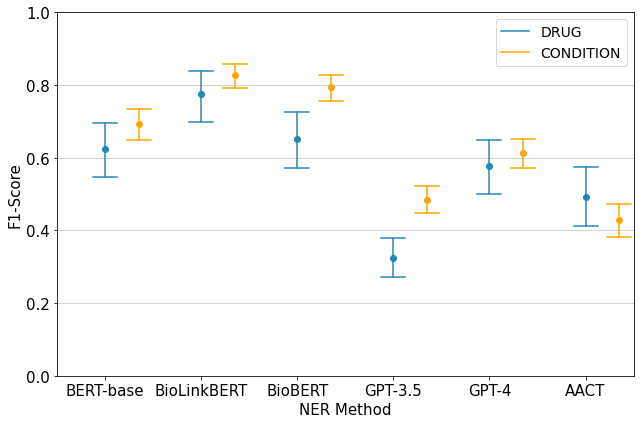

In [553]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6))  # You can adjust these values as needed

def plot_confidence_intervals(x, values1, values2, labels, legend=False, z=1.96, horizontal_line_width=0.25):
    mean1 = values1[1]
    top1 = values1[2]
    bottom1 = values1[0]

    mean2 = values2[1]
    top2 = values2[2]
    bottom2 = values2[0]

    left = x - horizontal_line_width / 2
    right = x + horizontal_line_width / 2
    
    if legend:
        plt.plot([x, x], [top1, bottom1], color=labels[0], label='DRUG')
        plt.plot([x + 0.35, x + 0.35], [top2, bottom2], color=labels[1], label='CONDITION')
    else:
        plt.plot([x, x], [top1, bottom1], color=labels[0])
        plt.plot([x + 0.35, x + 0.35], [top2, bottom2], color=labels[1])
        
    plt.plot([left, right], [top1, top1], color=labels[0])
    plt.plot([left, right], [bottom1, bottom1], color=labels[0])
    plt.plot([left + 0.35, right + 0.35], [top2, top2], color=labels[1])
    plt.plot([left + 0.35, right + 0.35], [bottom2, bottom2], color=labels[1])
    if legend:
        plt.plot(x, mean1, 'o', color=labels[0]) #, label='F1-Score'
    else:
        plt.plot(x, mean1, 'o', color=labels[0])
    plt.plot(x + 0.35, mean2, 'o', color=labels[1])
    plt.xlabel('NER Method', fontsize=15)  # Add x-axis label
    plt.ylabel('F1-Score', fontsize=15)    # Add y-axis label
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

model_names = ['BERT-base','BioLinkBERT', 'BioBERT', 'GPT-3.5', 'GPT-4', 'AACT']

# DRUG SCORES
bertbase_drug = drug_results_f1_majority['bert-base-uncased']
biolinkbert_drug = drug_results_f1_majority['BioLinkBERT-base']
biobert_drug = drug_results_f1_majority['biobert-v1.1']
gpt_drug = drug_results_f1_majority['gpt']
gpt4_drug = drug_results_f1_majority['gpt-4']
aact_drug = drug_results_f1_majority['aact']

# CONDITION SCORES
bertbase_condition = condition_results_f1_majority['bert-base-uncased']
biolinkbert_condition = condition_results_f1_majority['BioLinkBERT-base']
biobert_condition = condition_results_f1_majority['biobert-v1.1']
gpt_condition = condition_results_f1_majority['gpt']
gpt4_condition = condition_results_f1_majority['gpt-4']
aact_condition = condition_results_f1_majority['aact']

plt.xticks([1, 2, 3, 4, 5, 6], model_names, fontsize=15)
#plt.title('DRUG and CONDITION Recognition Performance')

plot_confidence_intervals(1, bertbase_drug, bertbase_condition, ['#2187bb', 'orange'], legend=True)
plot_confidence_intervals(2, biolinkbert_drug, biolinkbert_condition, ['#2187bb', 'orange'])
plot_confidence_intervals(3, biobert_drug, biobert_condition, ['#2187bb', 'orange'])
plot_confidence_intervals(4, gpt_drug, gpt_condition, ['#2187bb', 'orange'])
plot_confidence_intervals(5, gpt4_drug, gpt4_condition, ['#2187bb', 'orange'])
plot_confidence_intervals(6, aact_drug, aact_condition, ['#2187bb', 'orange'])

plt.grid(axis='y', alpha=0.7)
plt.ylim(0, 1)
plt.xlim(0.5, 6.5)  # Adjust the x-axis limits to reduce whitespace
plt.legend(fontsize=14)

plt.tight_layout()  # Adjust layout

plt.savefig(f'./evaluations/plots/abstract_level_majority_plot_with_CI_DRUG_CONDITION_20240129_prompt_{prompt_version_to_evaluate}.pdf')
plt.show()


In [104]:
for method in methods:
    print()
    for col_to_eval in col_names_to_eval:
        model = col_to_eval.split("_")[1]
        column_name = f"eval_{method}_{model}"
        print(f"*** {column_name} ***")
        calculate_mean_scores(df_interventions_eval, column_name, model, "interventions")


*** eval_exact_match_BioLinkBERT-base ***
Evaluated rows:  35
Mean p BioLinkBERT-base: 0.772
Mean r BioLinkBERT-base: 0.813
Mean f1 BioLinkBERT-base: 0.774
*** eval_exact_match_biobert-v1.1 ***
Evaluated rows:  39
Mean p biobert-v1.1: 0.662
Mean r biobert-v1.1: 0.648
Mean f1 biobert-v1.1: 0.645
*** eval_exact_match_gpt ***
Evaluated rows:  79
Mean p gpt: 0.312
Mean r gpt: 0.287
Mean f1 gpt: 0.29
*** eval_exact_match_aact ***
Evaluated rows:  41
Mean p aact: 0.461
Mean r aact: 0.415
Mean f1 aact: 0.422

*** eval_majority_BioLinkBERT-base ***
Evaluated rows:  35
Mean p BioLinkBERT-base: 0.777
Mean r BioLinkBERT-base: 0.827
Mean f1 BioLinkBERT-base: 0.785
*** eval_majority_biobert-v1.1 ***
Evaluated rows:  39
Mean p biobert-v1.1: 0.669
Mean r biobert-v1.1: 0.669
Mean f1 biobert-v1.1: 0.661
*** eval_majority_gpt ***
Evaluated rows:  79
Mean p gpt: 0.353
Mean r gpt: 0.332
Mean f1 gpt: 0.336
*** eval_majority_aact ***
Evaluated rows:  41
Mean p aact: 0.559
Mean r aact: 0.524
Mean f1 aact: 0

## DEMO how sequeval works

In [ ]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 618.2 kB/s eta 0:00:00 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16170 sha256=e72b5c23c9e1da5a54b9efd4ec0f4f743450e4753f6301bb4ff1c9fbed89c9db
  Stored in directory: /Users/donevas/Library/Caches/pip/wheels/e2/a5/92/2c80d1928733611c2747a9820e1324a6835524d9411510c142
Successfully built seqeval
DEPRECATION: prodigy 1.11.8 has a non-standard dependency specifier srsly>=2.0.0<3.0.0. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of prodigy or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [ ]:
from seqeval.metrics import classification_report
from seqeval.scheme import IOB2

y_true = [['O', 'O', 'O', 'B-MISC', 'I-MISC', 'I-MISC', 'O'], ['B-PER', 'I-PER', 'O']]
y_pred = [['O', 'O', 'B-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'O'], ['B-PER', 'I-PER', 'O']]

In [876]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [877]:
print(classification_report(y_true, y_pred, mode='strict', scheme=IOB2))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [932]:
y_true = [['B-NP', 'I-NP', 'O']]
y_pred = [['B-NP', 'B-NP', 'O']]

In [933]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

          NP       0.00      0.00      0.00         1

   micro avg       0.00      0.00      0.00         1
   macro avg       0.00      0.00      0.00         1
weighted avg       0.00      0.00      0.00         1



In [934]:
print(classification_report(y_true, y_pred, mode='strict', scheme=IOB2))

              precision    recall  f1-score   support

          NP       0.00      0.00      0.00         1

   micro avg       0.00      0.00      0.00         1
   macro avg       0.00      0.00      0.00         1
weighted avg       0.00      0.00      0.00         1



In [949]:
from transformers import AutoTokenizer
from datasets import load_dataset


In [935]:
model_name = "dmis-lab/biobert-v1.1"

In [938]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [947]:
relevant_data_path = "/Users/donevas/Desktop/Projects/Univeristy/PhD/Code/pythonNLP/clinical_trials_ner/corpus/second_annotation_round/"
corpus_files_path_prefix = relevant_data_path + "corpus_files/"
test_data_path_csv = corpus_files_path_prefix + "ct_neuro_test_merged_90.csv"
test_data_path = corpus_files_path_prefix + "ct_neuro_test_data_90.json"


In [1002]:
data_files = {"test": test_data_path}
raw_datasets = load_dataset("json", data_files=data_files)
predict_dataset = raw_datasets["test"]

In [992]:
predict_dataset

Dataset({
    features: ['tokens', 'ner_tags', 'id', 'word_tokenized_input'],
    num_rows: 90
})

In [996]:
tokenized_inputs = tokenizer(
        predict_dataset['tokens'],
        padding=True,
        truncation=True,
        max_length=512,
        # We use this argument because the texts in our dataset are lists of words (with a label for each word).
        is_split_into_words=True,
    )

In [ ]:
predict_dataset = predict_dataset.add_column("word_tokenized_input", [tokenized_inputs.tokens(batch_index=i) for i in range(len(predict_dataset))])
predict_dataset.to_csv("corpus/second_annotation_round/model_annotations/added_tokenized_words_col.csv")

In [997]:
i=1
word_ids = tokenized_inputs.word_ids(batch_index=i)
tokens = tokenized_inputs.tokens(batch_index=i)

In [998]:
tokenized_inputs[0]

Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [962]:
len(word_ids), len(tokens)

(512, 512)

In [970]:
label_all_tokens = False
labels = []
word_ids_list = []
tokens_list = []
word_ids = tokenized_inputs.word_ids(batch_index=i)
tokenized_tokens = tokenized_inputs.tokens(batch_index=i)
word_ids_list.append(word_ids)
previous_word_idx = None
label_ids = []
tokens_sub = [] # want to find out which of the tokens will be evaluated at the end, taking word-piece tokenization into account
for i, word_idx in enumerate(word_ids):
    # Special tokens have a word id that is None. We set the label to -100 so they are automatically
    # ignored in the loss function.
    if word_idx is None:
        label_ids.append(-100)
        tokens_sub.append(-100)
    # We set the label for the first token of each word.
    elif word_idx != previous_word_idx:
        label_ids.append(word_idx)
        tokens_sub.append(tokenized_tokens[i])
    # For the other tokens in a word, we set the label to either the current label or -100, depending on
    # the label_all_tokens flag.
    else:
        label_ids.append(word_idx if label_all_tokens else -100)
        tokens_sub.append(tokenized_tokens[i] if label_all_tokens else -100)
    previous_word_idx = word_idx

labels.append(label_ids)
tokens_list.append(tokens_sub)
tokenized_inputs["labels"] = labels
tokenized_inputs["word_ids"] = word_ids_list
tokenized_inputs["tokenized_tokens"] = tokens_list

In [238]:
#tokenized_inputs